# CARDIO CATCH DISEASES

## Business Problem

**Cadio Catch Diseases** is a company that specializes in detecting heart disease in the early stages.The company offers an early diagnosis of cardiovascular disease for a certain price. Currently, the diagosis is made manually. The currently accuracy used to be between 55% and 60%, because of the complex diagnostics and the team's tiredness, there's a another employees on other shifts.

There are some points that is important to know:
- **Each diagnosis costs about $1000,00**

- **The price will vary according to the precision, the customer pays $500.00 for every 5% accuracy above 50%.**

- **If the diagnostic precision is 50% or below, the customer doesn't pay for it.**


- What is the objective?
    - Build a predictive model to classify cardiovascular diseases.
    - Why is this necessary?
        - Because the price will vary according the precision. 

- What do we need to show?
    - The accuracy and precision of the model.
    - How much profit will Cardio Catch Diseases have after the project? 
    - How reliable is our result?
    
   
- Business problem reference: https://sejaumdatascientist.com/projeto-de-data-science-diagnostico-precoce-de-doencas-cardiovasculares/



### Cardiovascular Diseases: What is it?

Cardiovascular diseases (CVDs) are a group of disorders of the heart and blood vessels and they include:

- coronary heart disease – disease of the blood vessels supplying the heart muscle;
- cerebrovascular disease – disease of the blood vessels supplying the brain;
- peripheral arterial disease – disease of blood vessels supplying the arms and legs;
- rheumatic heart disease – damage to the heart muscle and heart valves from rheumatic fever, caused by streptococcal bacteria;
- congenital heart disease – malformations of heart structure existing at birth;
- deep vein thrombosis and pulmonary embolism – blood clots in the leg veins, which can dislodge and move to the heart and lungs.


References: [World Health Organization]("https://www.who.int/en/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)")

# 0.0. IMPORTS

In [3]:
#data manipulation
import pandas                as pd
import numpy                 as np

#data visualization
import seaborn               as sns
import matplotlib.pyplot     as plt
from scikitplot              import metrics      as mt

#scikit-learn
from sklearn.preprocessing   import RobustScaler,MinMaxScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score,cross_val_predict,RandomizedSearchCV
from sklearn.ensemble        import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import accuracy_score, classification_report,cohen_kappa_score,recall_score,f1_score,roc_auc_score, plot_precision_recall_curve, precision_score,roc_curve
from sklearn.pipeline        import Pipeline
from sklearn.neighbors       import KNeighborsClassifier
from sklearn                 import svm

#balanced imports
from imblearn import under_sampling as us
from imblearn import over_sampling as oversamp
from imblearn import combine as c

#auxiliar packages
from IPython.display         import Image
from IPython.core.display    import HTML
from scipy                   import stats
from math                    import sqrt
from tabulate                import tabulate
from boruta                  import BorutaPy
import xgboost               as xgb
from lightgbm                import LGBMClassifier
import random
import pickle

## 0.1. Helper Functions

In [6]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
# point biserial correlation coefficient heatmap function
def point_bi(a, b):
    # a: input dataframe with binary variable
    # b: input dataframe with continuous variable
    
    # get column name
    a_name = a.columns[0]
    b_name = b.columns[0]
    
    # transform dataframe to array
    a = a.values.reshape(-1)
    b = b.values.reshape(-1)
    
    # apply scipy's point-biserial
    stats.pointbiserialr(a, b)
    
    # correlation coefficient array
    c = np.corrcoef(a,b)
    
    # dataframe for heatmap
    df = pd.DataFrame(c, columns=[a_name, b_name], index=[a_name, b_name])
    
    # return heatmap
    return sns.heatmap(df, annot=True).set_title('{} x {} correlation heatmap'.format(a_name, b_name),fontsize = 25);

In [7]:
#setting the function
jupyter_settings()

## 0.2. Loading Data

The dataset consists of 70 000 records of patients data in 12 features and the target feature that will tell to us the diagnostic.  We can find the data on  [kaggle]("https://www.kaggle.com/sulianova/cardiovascular-disease-dataset") website.

- Age | Objective Feature | age | int (days)

- Height | Objective Feature | height | int (cm) |
- Weight | Objective Feature | weight | float (kg) |
- Gender | Objective Feature | gender | categorical code |
- Systolic blood pressure | Examination Feature | ap_hi | int |
- Diastolic blood pressure | Examination Feature | ap_lo | int |
- Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
- Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
- Smoking | Subjective Feature | smoke | binary |
- Alcohol intake | Subjective Feature | alco | binary |
- Physical activity | Subjective Feature | active | binary |
- Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

**Let's load the data to start our solution!!!**

In [8]:
#loading dataset as a dataframe
df_raw = pd.read_csv("data/cardio_train.csv", sep = ';')

# 1.0. DATA DESCRIPTION

Generally, descriptive analysis is the first manipulation performed in a quantitative study and its main objective is to summarize and explore the behavior of the data. This can be done through frequency tables, graphs and numerical summary measures. Before presenting each of these items, let's first make a copy of our dataset. After that, we'll do the follow steps:

- Data Dimension
- Data Types
- Check Missings Values
- Change Types
- Descriptive Statistical

In [9]:
#making a copy of the data
df1 = df_raw.copy()

## 1.1. Data Dimension

Understanding how much big is our dataset is, it's essential to comprehend if our infrastructure is enough to run the model or not. It's important to know that there are two data classifications : big data and tradicional data. As we can see below, we have 70000 rows and 13 columns, therefore, we won't need to have a powerful computer to execute the machine learning model. One point that needs to be checked is if we have enough data to ensure learning.

In [10]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of columns: {}".format(df1.shape[1]))

Number of rows: 70000
Number of columns: 13


## 1.2. Data Types

As we can see bellow, we have 2 data types: **int64** and **float64**. It's important to explain that machine learning algorithms usually build a better learning with numerical data, this is one of the premises that we will assume. 

In [11]:
#checking the types
df1.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

## 1.3. Check Missing Data

Missing values are the Achilles' heel of a data scientist. If not handled properly, the entire analysis will be futile and will provide misleading results that can harm business stakeholders. However, as we can analyze below, we did not find any column that has missing data, this will avoid a lot of work.

In [12]:
#checking missing data
df1.isnull().sum()/df1.shape[0]

id             0.0
age            0.0
gender         0.0
height         0.0
weight         0.0
ap_hi          0.0
ap_lo          0.0
cholesterol    0.0
gluc           0.0
smoke          0.0
alco           0.0
active         0.0
cardio         0.0
dtype: float64

## 1.4. Change Types

The "id" column is a "int64" but, we won't execute any mathmatical operation because it is just a indentifying column. Therefore, we could change it to a categorical data or maybe to drop it, but let's to change the type to "object". Another point that we need to note is that our "age" column has an "days" format, so let's switch to the "age" format.

In [13]:
#coverting the age column to the years format
df1['age_year'] = df1['age'].apply(lambda x: x/365)

#age_year convert
df1['age_year'] = df1['age_year'].astype(int)

#changing id type to object
df1['id'] = df1['id'].astype("object")

In [14]:
df1.dtypes

id              object
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
age_year         int64
dtype: object

## 1.5. Descriptive Statistical

### 1.5.1. Numerical Attributes

A descriptive statistic is a summary statistic that quantitatively describes or summarizes features from a collection of information. Some measures that are commonly used to describe a dataset are measures of central tendency and measures of variability or dispersion. Measures of central tendency include the mean, median and mode, while measures of variability include the standard deviation (or variance), the minimum and maximum values of the variables, kurtosis and skewness. But, let's understand what really is skewness and kurtosis.

- Skewness is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.

- Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers. A uniform distribution would be the extreme case.

In [15]:
#filtering all the numerical data
num_attributes = df1.select_dtypes(exclude = ['object'])

#dropping the binary features
num_attributes.drop(columns = ['gluc','smoke','alco','active','cardio','cholesterol'], axis = 1, inplace = True)

#central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#dipersion - std,min,max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concat as a unique dataframe
desc_stats = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

desc_stats.columns = columns
desc_stats

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,10798.0,23713.0,12915.0,19468.865814,19703.0,2467.234044,-0.307055,-0.823447
1,gender,1.0,2.0,1.0,1.349571,1.0,0.476835,0.630960,-1.601935
2,height,55.0,250.0,195.0,164.359229,165.0,8.210068,-0.642187,7.943653
3,weight,10.0,200.0,190.0,74.205690,72.0,14.395654,1.012070,2.586825
4,ap_hi,-150.0,16020.0,16170.0,128.817286,120.0,154.010319,85.296214,7580.074738
5,ap_lo,-70.0,11000.0,11070.0,96.630414,80.0,188.471184,32.114083,1425.914585
6,age_year,29.0,64.0,35.0,52.840671,53.0,6.766725,-0.305744,-0.818981


From this table, we can get some informations:

- There aren't children included in the dataset

- The minimum value for the "height" column is 55, but the minimum value for the age_year column is 29. As we said, we don't have children included in the data set

- "ap_hi" and "ap_lo have a high skew, this probably means that we have a non-symmetric graph shifted to the right.

- If we remember that a person who has systolic blood pressure of 180mmHg must urgently go to the doctor and with a diastolic pressure greater than 120mmHg. However, we have as maximum values in the columns "ap_hi" and "ap_lo" the values 16020.0 and 11000.0 respectively. This is a strange value that needs to be analyzed soon, but it could indicates that it is an outlier.

- There are also negative values for the columns "ap_hi" and "ap_lo", this represents an inconsistent value.

### 1.5.2. Binary and Ordinal Attributes

/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

<AxesSubplot:xlabel='cholesterol', ylabel='count'>

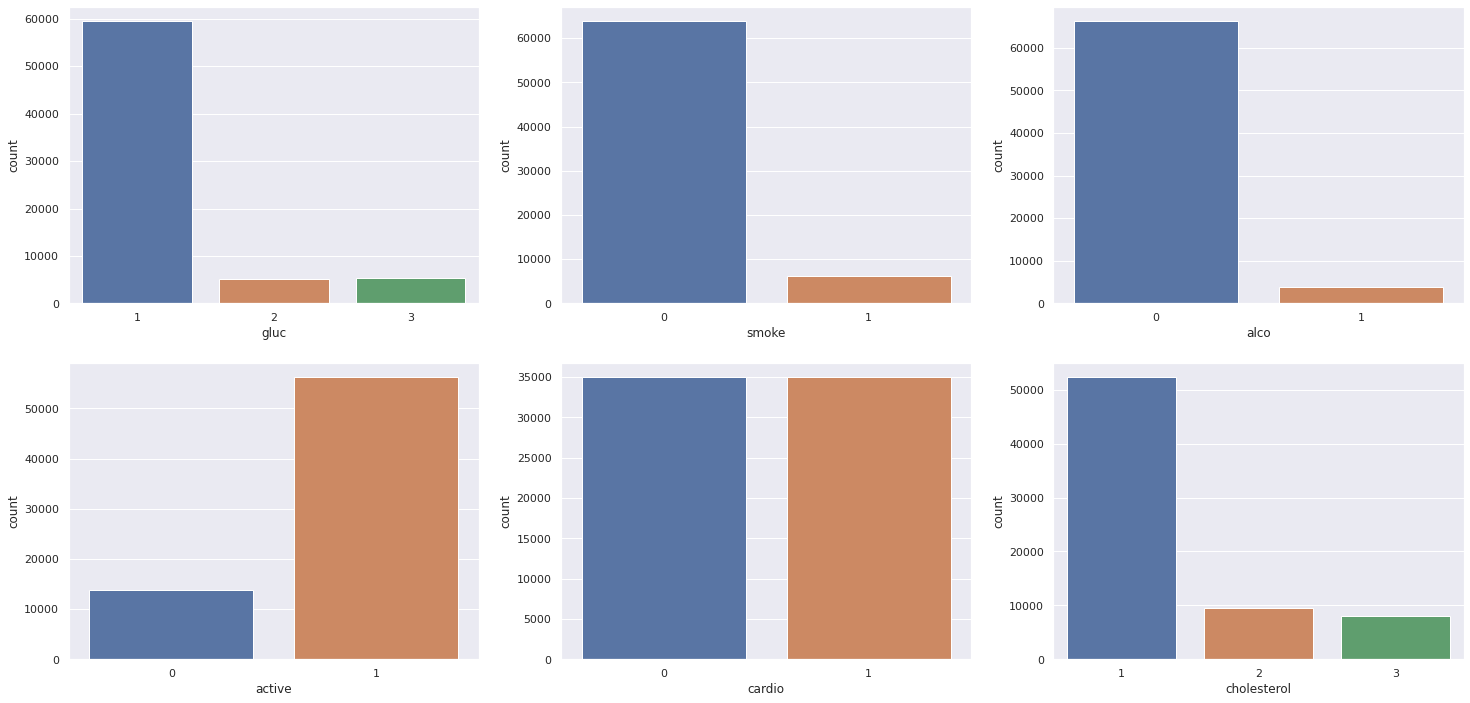

In [16]:
#filtering each binary attributes from our original dataframe
binary_attributes = df1[['gluc','smoke','alco','active','cardio','cholesterol']]

#plotting each feature from binary_attributes dataframe
plt.subplot(2,3,1)
sns.countplot(binary_attributes['gluc'])

plt.subplot(2,3,2)
sns.countplot(binary_attributes['smoke'])

plt.subplot(2,3,3)
sns.countplot(binary_attributes['alco'])

plt.subplot(2,3,4)
sns.countplot(binary_attributes['active'])

plt.subplot(2,3,5)
sns.countplot(binary_attributes['cardio'])

plt.subplot(2,3,6)
sns.countplot(binary_attributes['cholesterol'])

From these plots we can get some informations:

**1.** There is much more data from people with normal glucose levels.

**2.** Our target variable has balanced data, which is very good, it will avoid a lot of work.

**3.** The number of people who do physical activities is considerably greater than those who don't.

# 2.0. FEATURE ENGINEERING

A feature could be strongly relevant, the feature has information that doesn't exist in any other feature, relevant, weakly relevant (some information that other features include) or irrelevant. Even if some features are irrelevant, having too many is better than missing those that are important. 

The feature engineering process is:

- Creating a mind map hypothesis;
- Deciding what features to create;
- Creating features;

In [17]:
#making a copy of the dataset
df2 = df1.copy()

## 2.1. MindMap Hypothesis

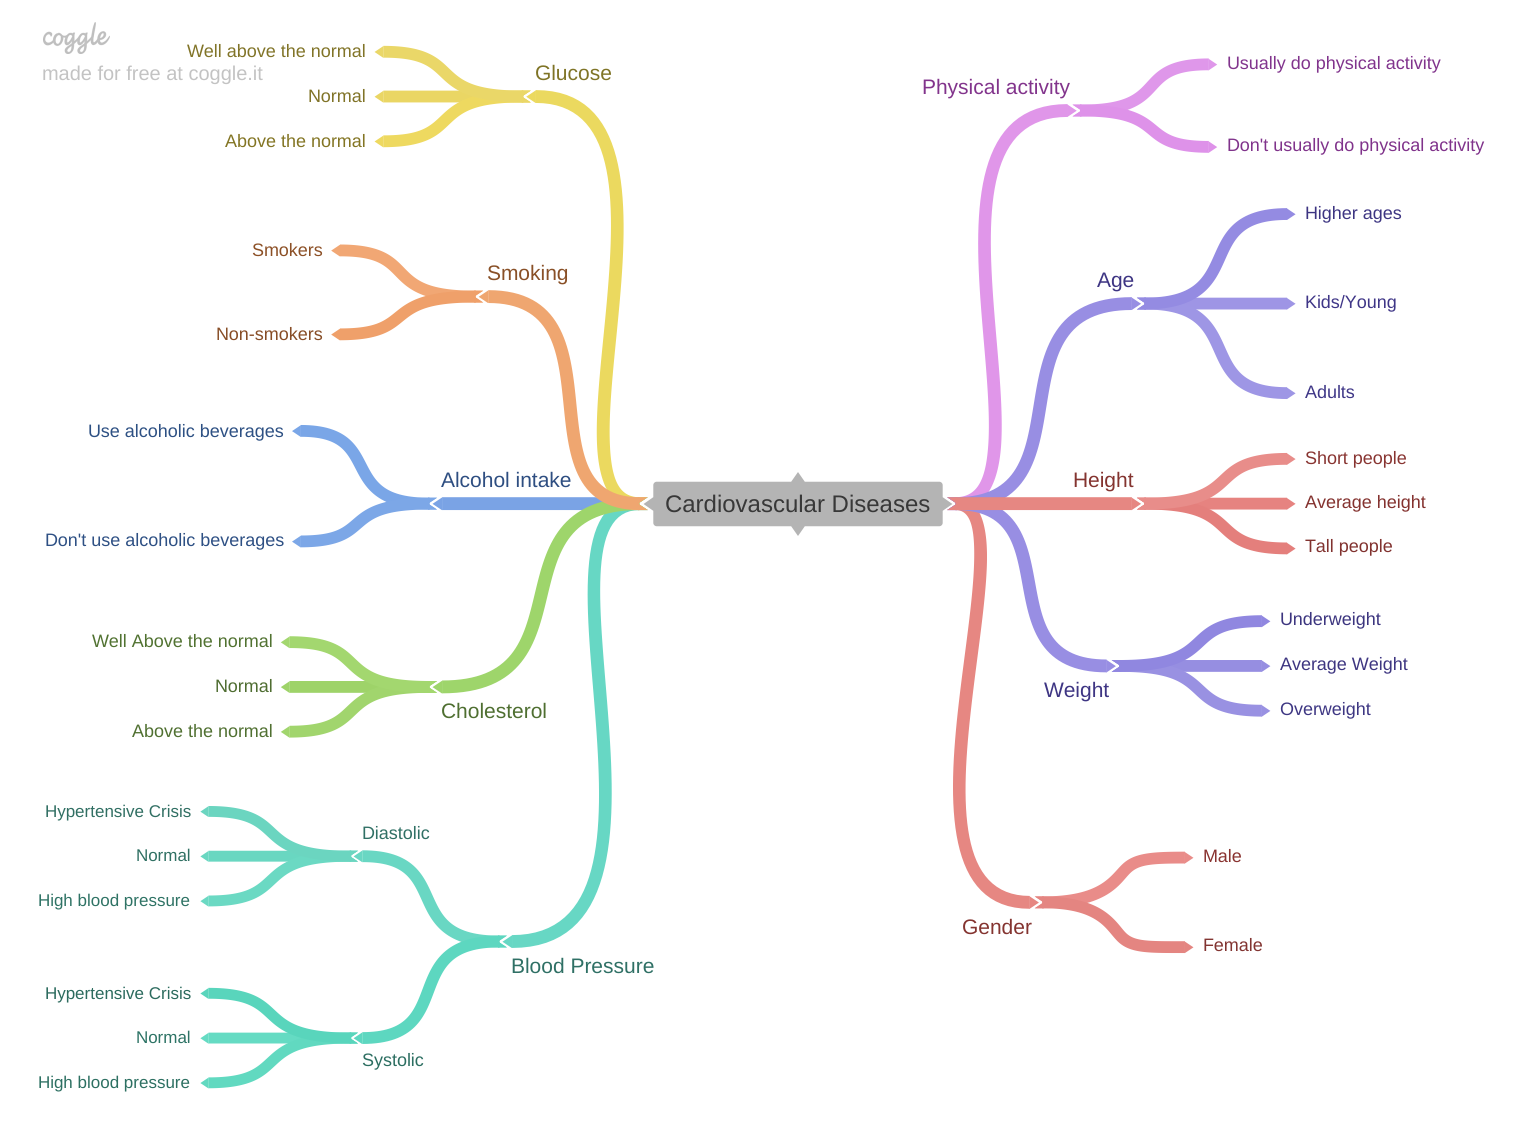

In [18]:
Image("img/MindMapHypothesis.png")

## 2.2. Hypothesis List

**1.** **AGE**
   - There are more cases of cardiovascular disease in older people.
    
**2.** **GENDER**
   - The presence of cardiovascular diseases will not depend directly on gender.
    
**3.** **BLOOD PRESSURE**
   - There are more cases of cardiovascular disease in people with high diastolic and systolic pressure.
    
**4.** **SMOKING**
   - There are more cases of cardiovascular disease in people who smoke.
    
**5.** **ALCOHOL INTAKE**
   - There are more cases of cardiovascular disease in people who drink alcoholic beverages
    
**6.** **WEIGHT**
   - There are more cases of cardiovascular disease in people who are overweight.

**7.** **PHYSICAL ACTIVITY**
   - There are fewer cases of cardiovascular disease in people who practice physical activity
    
**8.** **GLUCOSE**
   - There are more cases of cardiovascular disease in people who have a high glucose rate.
    
**9.** **CHOLESTEROL**
   - There is a incresed risk of cardiovascular disease if your cholesterol is above normal.
   
**10.** **HEIGHT**
   - The presence of cardiovascular diseases is not influenced by height.

## 2.3. Feature Engineering

### 2.3.1. Blood Pressure

We will create a new variable to make it easier to visualize in the exploratory data analysis stage. This feature will be derived from our systolic and diastolic pressure values. We will classify them into groups as shown below:

   - Normal -> Systolic Less than 120 and diastolic less than 80
   - Elevated -> Systolic between 120-129 and diastolic less than 80
   - High Blood Pressure -> Systolic between 130-139 and diastolic between 80-89
   - Hypertension -> Systolic above the 140 and diastolic equal or above the 90.

In [19]:
#blood pressure
df2['blood_pressure'] = df2.apply(lambda x:'normal' if (x['ap_hi'] <= 120) & (x['ap_lo'] <= 80)
                                 else 'elevated' if (x['ap_hi'] > 120 and x['ap_hi'] <= 129) & (x['ap_lo'] <= 80)
                                 else "high_blood_pressure" if (x['ap_hi'] >= 130 and x['ap_hi'] <= 139) & (x['ap_lo'] <= 90)
                                 else 'hypertension', axis = 1)

### 2.3.2. Weight

Overweight and obesity are defined by the World Health Organization as abnormal or excessive fat that accumulate and present a risk to health. Obesity is measured in body mass index (BMI), which is a person’s weight (in kilograms) divided by the square of his or her height (in meters). A person with a BMI of 30 or more is generally considered obese. A person with a BMI equal to or more than 25 is considered overweight.

Therefore, the creation of the variable "bmi" will be more faithful than just the variable "weight", because sometimes we have people with high weight but with high height. So, the weight is directly proportional to the height.


**BMI = Weight(kg) / (Height)²(m²)**

Reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3250069/

As our "height" column is in centimeters, we will have to convert it to square meter. Therefore, we will divide by 10,000

**m² = cm²/10000**

Reference: https://www.asknumbers.com/square-centimeter-to-square-meter.aspx#:~:text=1%20Square%20meter%20(m2)%20is,100000%20cm2%20is%2010%20m2.

In [20]:
#bmi calculation
df2['bmi'] = round((df2['weight']/((df2['height'] * df2['height'])/10000)),2)

From this, we will derive our feature "status_bmi" which will be represented according to the image below.

In [21]:
#creating status_bmi 
df2['status_bmi'] = df2['bmi'].apply(lambda x: 'underweight' if x <= 18.5
                                          else 'normal' if (x > 18.5) & (x < 24.9) 
                                          else 'overweight' if (x >= 25) & (x <= 29.9)
                                          else 'obse' if (x >= 30) & (x<= 34.9) 
                                          else 'extremely_obese')

### 2.3.3 Age

We will build groups for the ages to be easy in the hypothesis validation stage.

The groupings will be:
- 0-50
- 50-65
- above 65

In [22]:
#creating age rage
df2['age_range'] = df2['age_year'].apply(lambda x:"0-50" if x <= 50
                                             else "50-65" if (x>50) & (x<=65)
                                             else ">65")

# 3.0. DATA FILTERING

In [23]:
#making a new copy of the dataframe
df3 = df2.copy()

## 3.1. Filtering Columns

we will remove the columns. These will be:

1. **id** - This column is just a unique identifier for each person. Therefore, it will not be interesting for our model.

2. **age** - This column is in the format of days, as we built another column with the age in years, it would be redundant to keep both, because we will have the same information in different formats.

In [24]:
cols_drop = ['age','id']
df3.drop(columns = cols_drop, axis = 1, inplace = True)

## 3.2. Filtering Rows --> Removing Outliers

In [25]:
#copying a new dataframe
df3_clean = df3.copy() 

Let's check the inconsistencies in the following columns:

- ap_hi
- ap_lo
- height
- weight

### 3.2.1 Blood Pressure

#### 3.2.1.1 Systolic Blood Pressure

/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'With Filter')

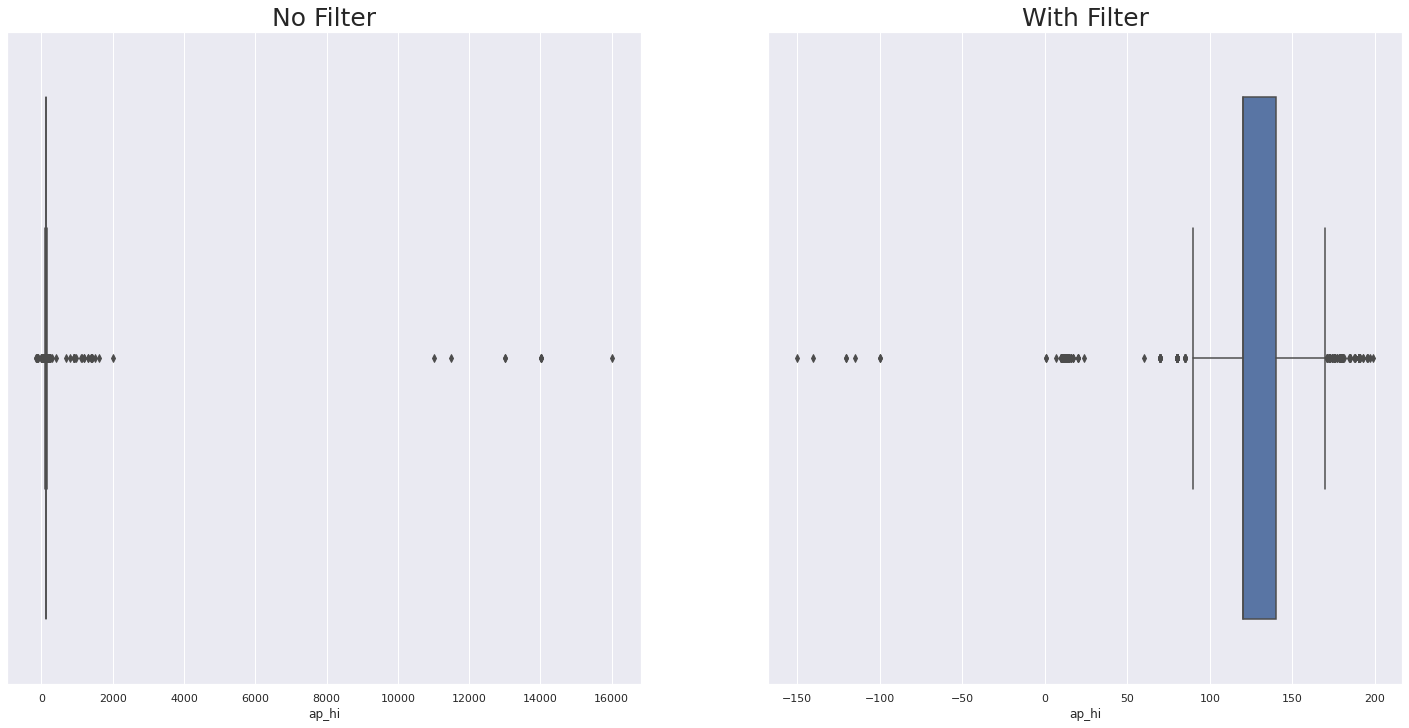

In [26]:
#boxplot no filter
plt.subplot(1,2,1)
sns.boxplot(df3_clean['ap_hi'])
plt.title("No Filter", fontsize = 25)

#boxplot with filter
plt.subplot(1,2,2)
aux1 = df3_clean[df3_clean['ap_hi'] < 200]
sns.boxplot(aux1['ap_hi'])
plt.title("With Filter", fontsize = 25)

We chose to keep some values outside the 3rd quartile because a patient with a blood pressure of 190/90 mmHg or 175/115 has a hypertensive crisis. The higher the blood pressure, the more severe the crisis. Some patients even have 240 or 250 mmHg of maximum pressure during a hypertensive peak.

From the boxplot, we can identify a large presence of outliers, even applying a filter for better visualization of the quartiles. Therefore, analyzing statistically, we will remove the following values:

- **Systolic** <= 90 and **Systolic** >= 220

#### 3.2.1.2 Diastolic Blood Pressure

/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'With Filter')

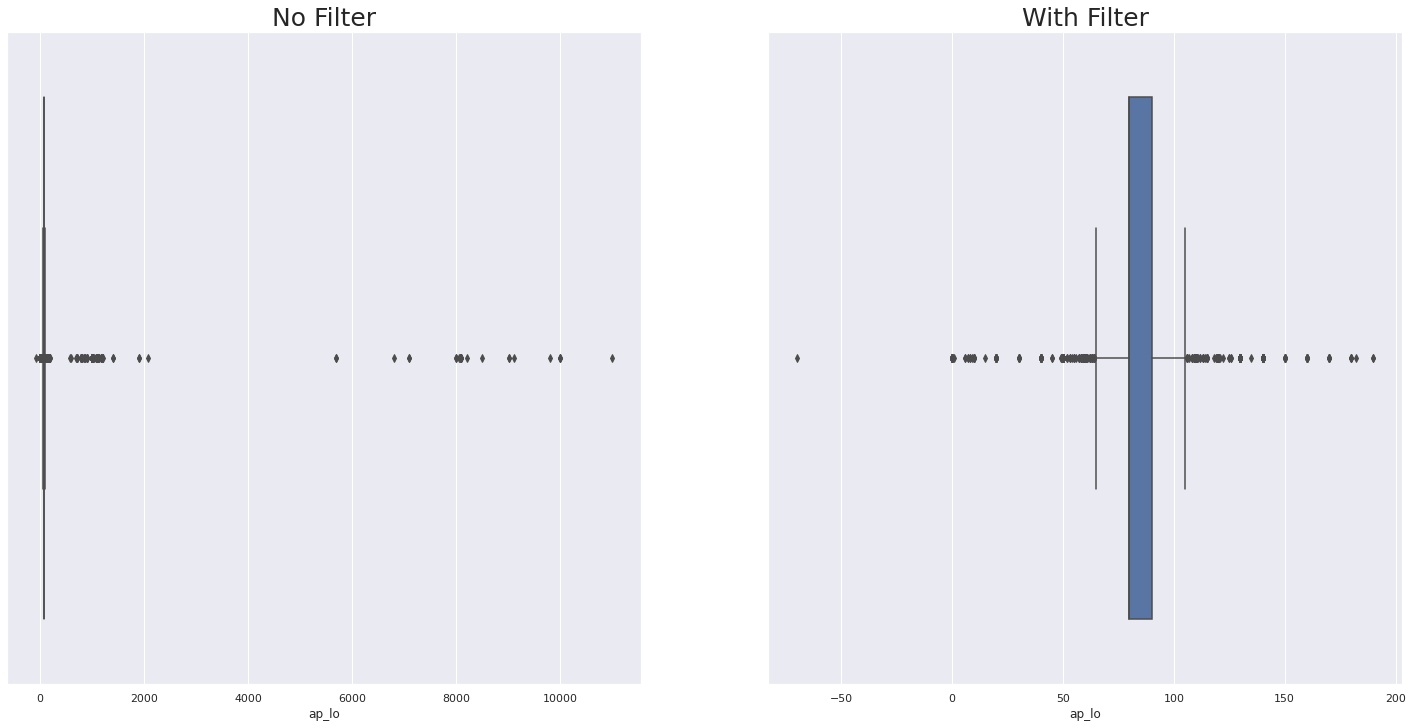

In [27]:
#boxplot no filter
plt.subplot(1,2,1)
sns.boxplot(df3_clean['ap_lo'])
plt.title("No Filter", fontsize = 25)

#boxplot with filter
plt.subplot(1,2,2)
aux1 = df3_clean[df3_clean['ap_lo'] < 200]
sns.boxplot(aux1['ap_lo'])
plt.title("With Filter", fontsize = 25)

From the boxplot, we can identify a large presence of outliers, even applying a filter for better visualization of the quartiles. Therefore, analyzing statistically, we will remove the following values:

- **Diastolic** <= 65 and **Diastolic** >= 150

#### 3.2.1.3 Removing Outliers

Let's remove the following values:

- Systolic >= 210 and Diastolic >=150
- Systolic <= 90 and Diastolic <= 65

In [28]:
#removing outliers
df3_clean = df3_clean[~((df3_clean['ap_hi'] >= 220) | (df3_clean['ap_hi'] <= 90) 
                        | (df3_clean['ap_lo'] >= 150) | (df3_clean['ap_lo'] <= 65))]

/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Systolic')

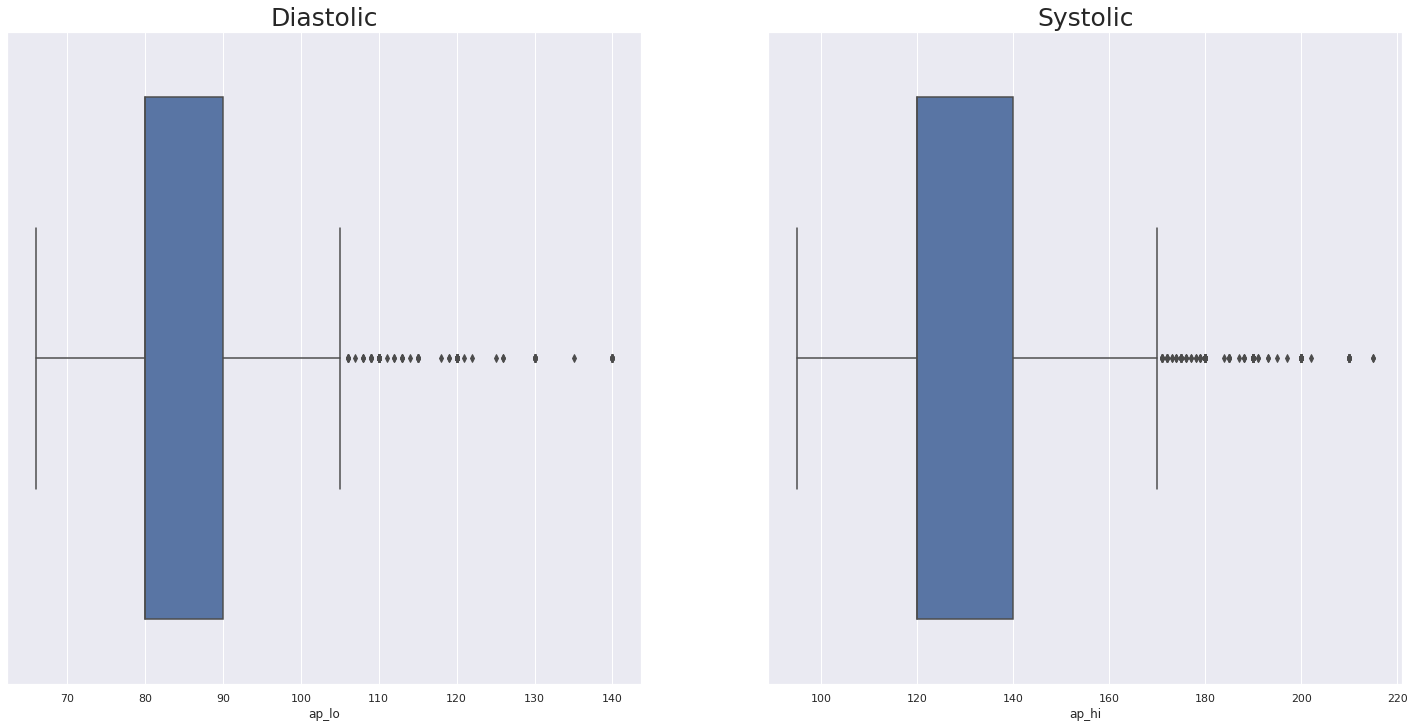

In [29]:
#building a boxplot without outliers
plt.subplot(1,2,1)
sns.boxplot(df3_clean['ap_lo'])
plt.title("Diastolic", fontsize = 25)

plt.subplot(1,2,2)
sns.boxplot(df3_clean['ap_hi'])
plt.title("Systolic", fontsize = 25)

As we see above, there is some data that is outside the boxplot. However, we will consider, therefore, there are cases in which, due to systemic problems, this variation can happen.

### 3.2.2 Height 

As noted in the descriptive analysis, we have some inconsistencies in our height variable that needed to be checked. Among them, a person who had 55cm, this is extremely unusual. Therefore, after some research, I found that the height of a dwarf is approximately 140 cm,so, if we don't remove these values that are out of reality, we could add a bias that we don't want. We also found that the height of the tallest human in the world is 246cm, which is beyond normal.

/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='height', ylabel='Density'>

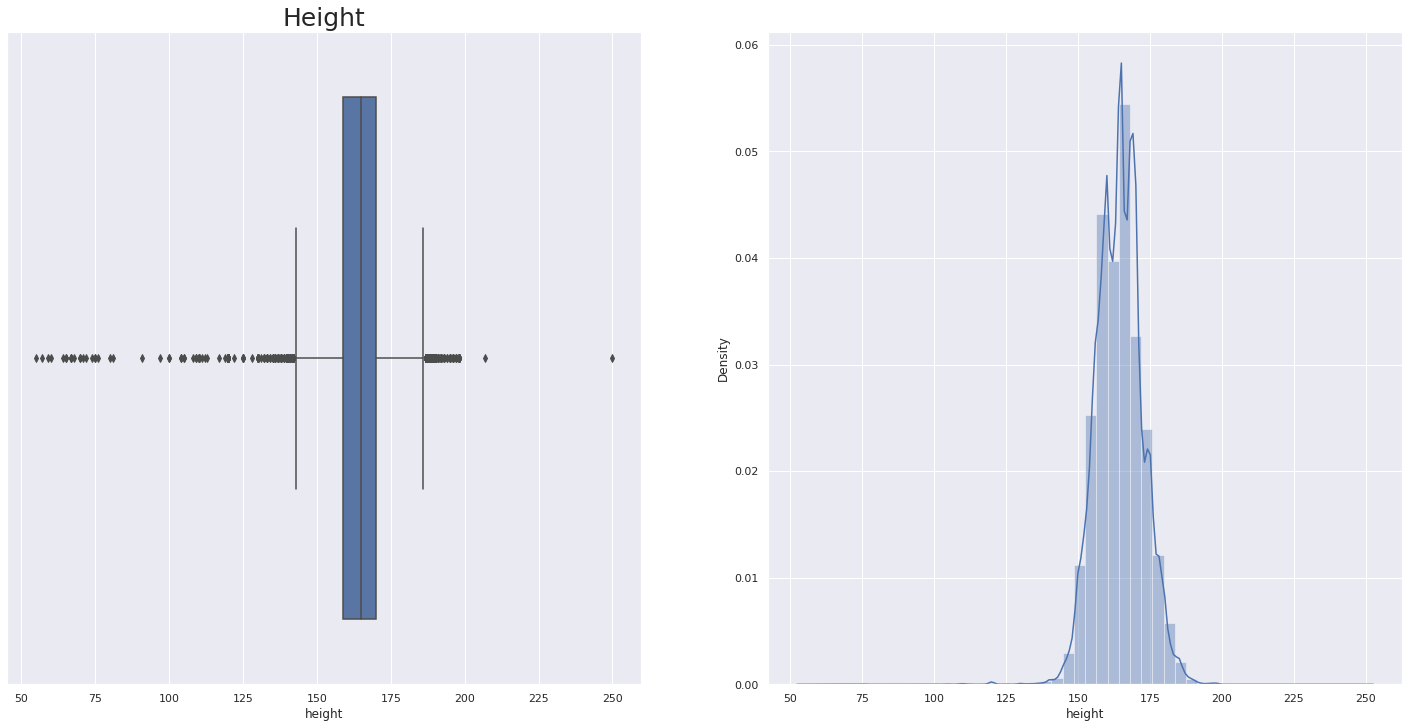

In [30]:
#boxplot no filter
plt.subplot(1,2,1)
sns.boxplot(df3_clean['height'])
plt.title("Height", fontsize = 25)

#distribution plot
plt.subplot(1,2,2)
sns.distplot(df3_clean['height'])

So, we will consider the following values:

- values > 140cm
- values < 215cm 

In [31]:
#filtering values
df3_clean = df3_clean[(df3_clean['height'] > 140) & (df3_clean['height'] < 220)]

/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='height', ylabel='Density'>

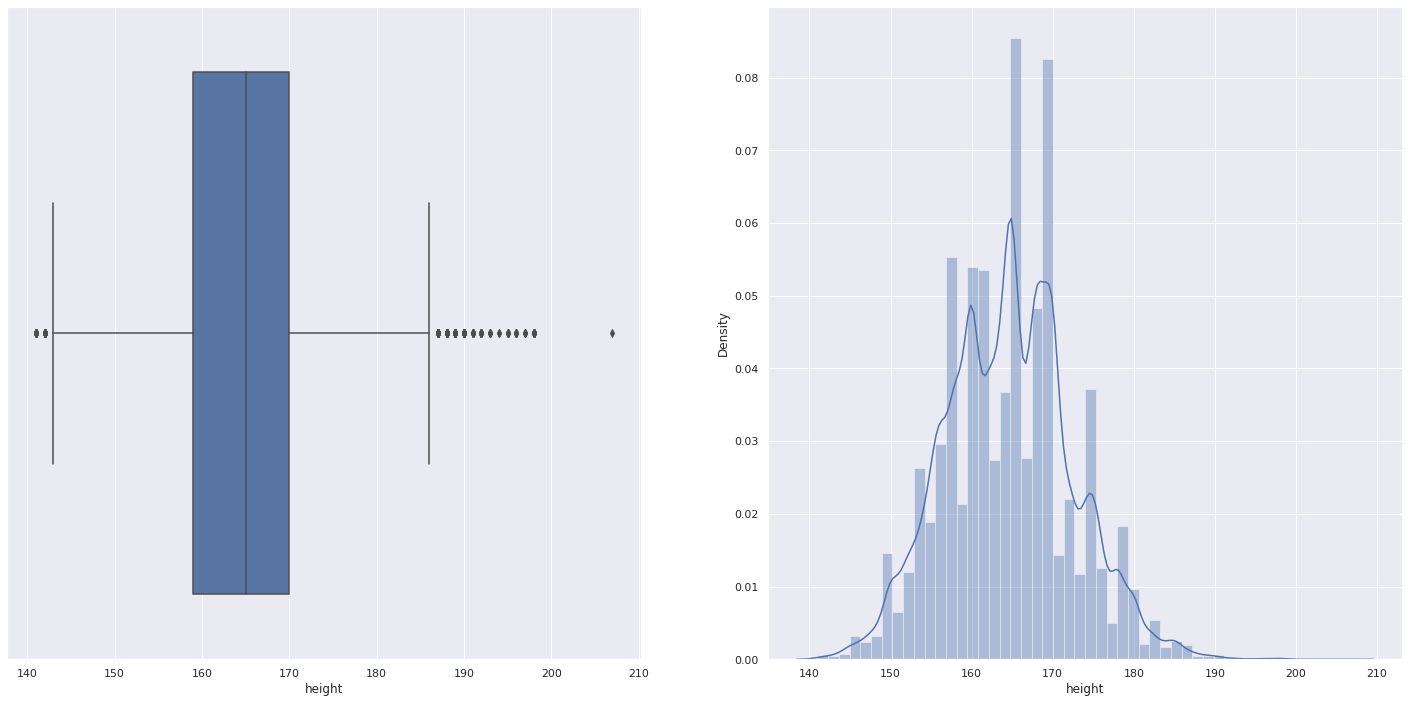

In [32]:
#boxplot
plt.subplot(1,2,1)
sns.boxplot(df3_clean['height'])

#distribuition plot
plt.subplot(1,2,2)
sns.distplot(df3_clean['height'])

After removing the outliers, we obtain a distribution similar to Gaussian, but with more oscillations.

### 3.3.3. Weight

As our goal is to forecast medical diagnoses, for safety reasons, we will remove the values of the weight variable that are less than 43kg.

/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='weight'>

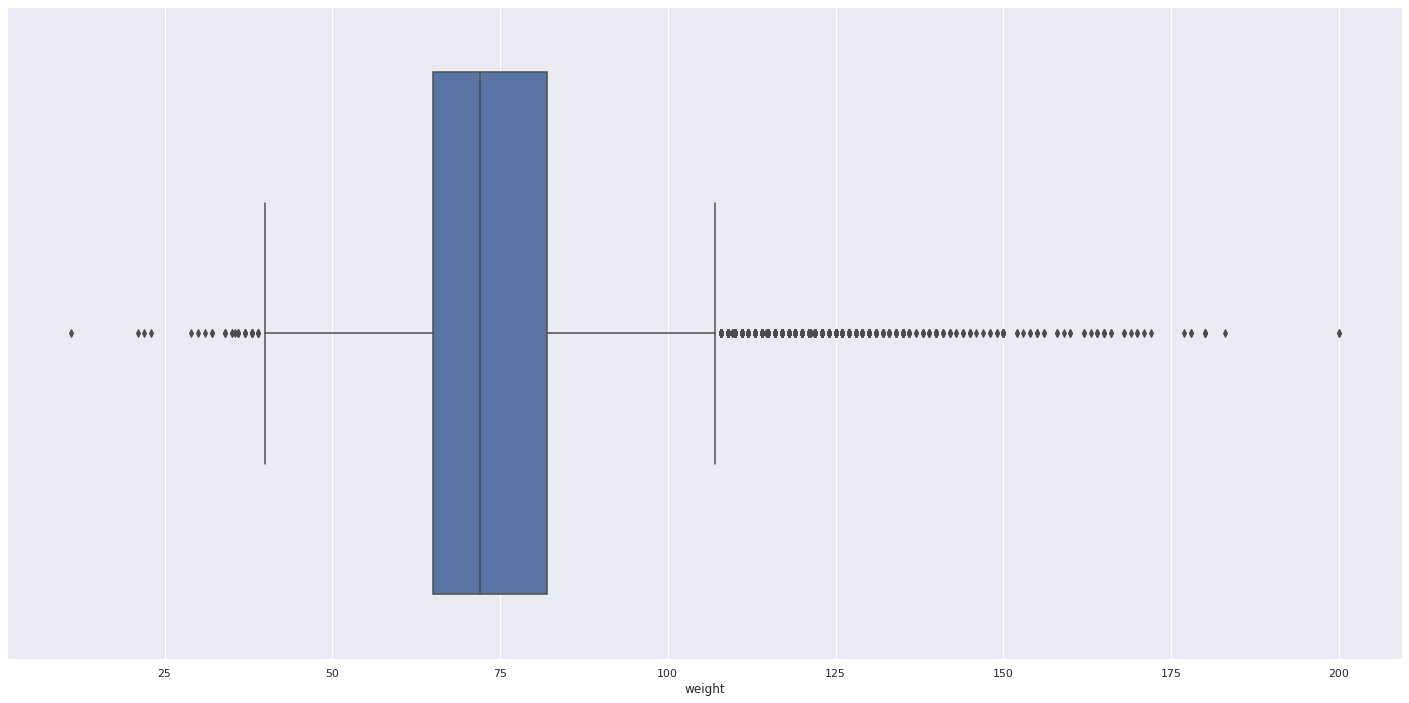

In [33]:
sns.boxplot(df3_clean['weight'])

/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='weight'>

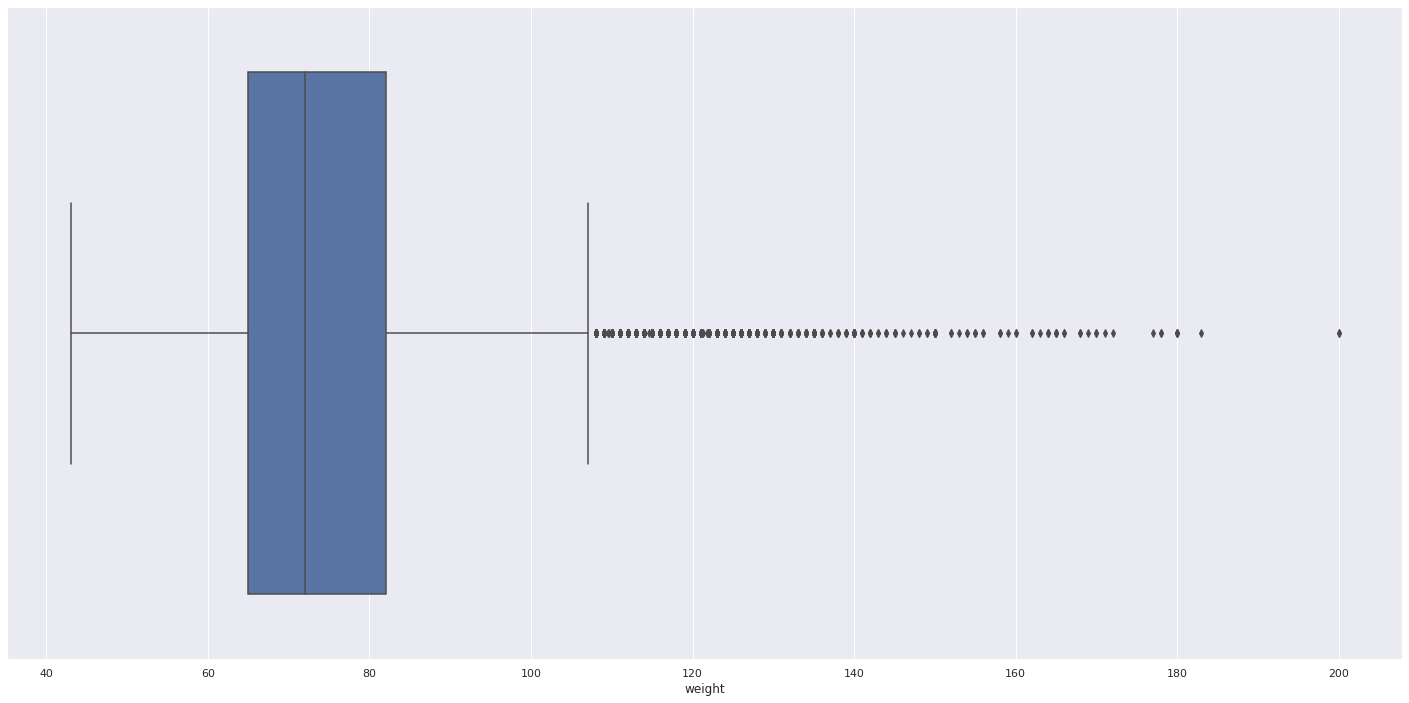

In [34]:
#removing inconsistent values.
df3_clean = df3_clean[~(df3_clean['weight'] < 43)]

sns.boxplot(df3_clean['weight'])

# 4.0. EXPLORATORY DATA ANALYSIS

Exploratory Data Analysis (EDA) is the process of visualizing and analyzing data to extract insights from it. In other words, EDA is the process of summarizing important characteristics of data in order to gain better understanding of the dataset. Therefore, this part will be done in the following three steps:

- Univariate Analysis
- Bivariate Analysis
- Multivariate Analysis

In [35]:
df4 = df3_clean.copy()

## 4.1. Univariate Analysis

### 4.1.1 Response Variable

/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cardio', ylabel='count'>

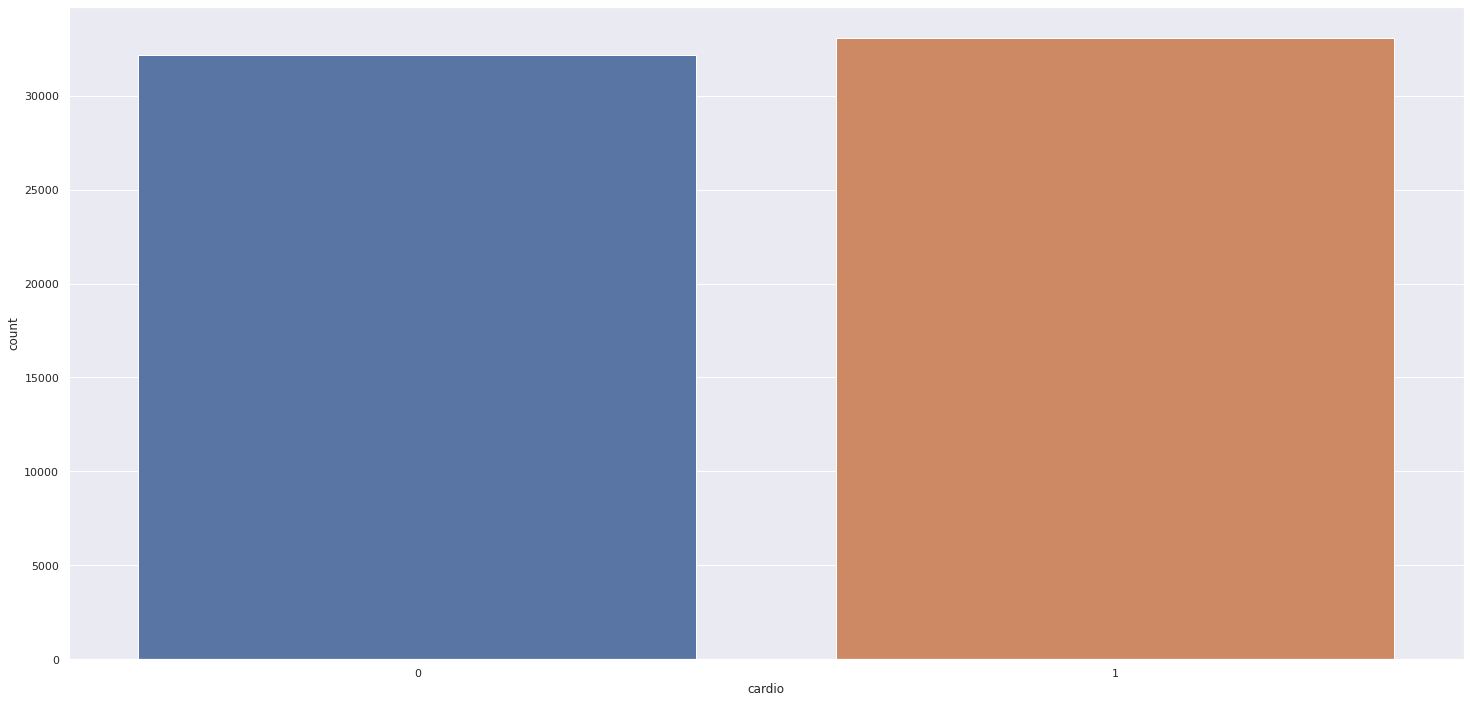

In [36]:
#building a countplot to our response variable
sns.countplot(df4['cardio'])

As we can see, we have our classes balanced.

### 4.1.2 Numerical Variable

In [37]:
#selecting numerical variables
num_attributes = df4.select_dtypes(exclude = ['object'])

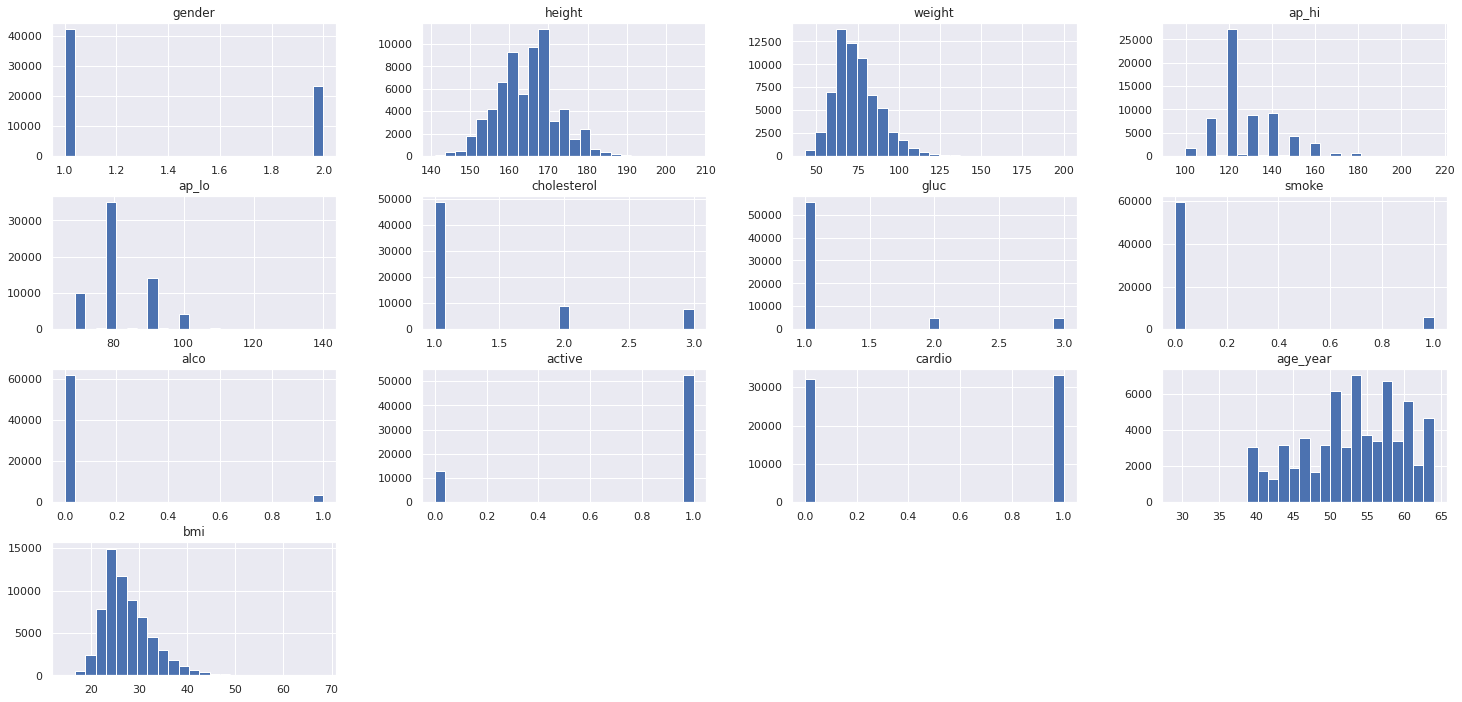

In [38]:
#plotting histogram
num_attributes.hist(bins = 25);

From the graphs above, we can get some conclusions:

- **gender** 
    - Our class that has the gender "1" has almost twice the gender class "2".
- **height**
    - It has a distribution similar to a normal one.
- **weight** 
    - It has a distribution similar to a normal one.
- **bmi**
    - It has a distribution similar to a normal one.

### 4.1.3 Categorical Variable

In this subsection, we will focus on analyzing our categorical variables and which have some qualitative interpretation, such as our "cholesterol" variable.

In [39]:
#selecting "categorical" variables
cat_attributes = df4[['cholesterol','gluc','smoke','alco','active','blood_pressure','status_bmi','age_range','gender']]

/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

<AxesSubplot:xlabel='gender', ylabel='count'>

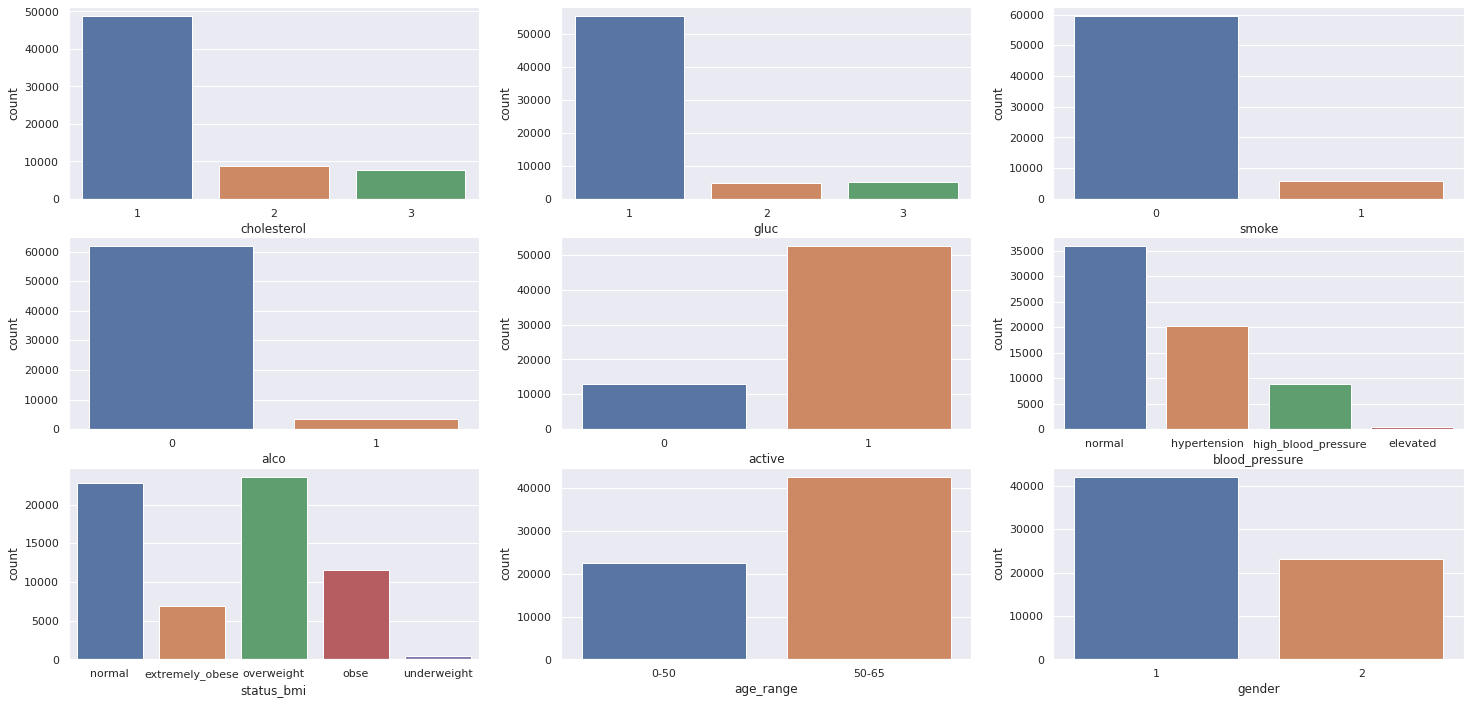

In [40]:
#plotting each variable
plt.subplot(3,3,1)
sns.countplot(cat_attributes['cholesterol'])

plt.subplot(3,3,2)
sns.countplot(cat_attributes['gluc'])

plt.subplot(3,3,3)
sns.countplot(cat_attributes['smoke'])

plt.subplot(3,3,4)
sns.countplot(cat_attributes['alco'])

plt.subplot(3,3,5)
sns.countplot(cat_attributes['active'])

plt.subplot(3,3,6)
sns.countplot(cat_attributes['blood_pressure'])

plt.subplot(3,3,7)
sns.countplot(cat_attributes['status_bmi'])

plt.subplot(3,3,8)
sns.countplot(cat_attributes['age_range'])

plt.subplot(3,3,9)
sns.countplot(cat_attributes['gender'])

 From these plots, we've got some informations:
 
- The number of people with normal weight and overweight are very close. The number of obese people is half the number of people with normal weight.
 
- There are twice as many people between 50-65 than 0-50.
 
- There are almost twice as many people of gender 1 compared to 2.
 
- The number of hypertensive people is half that of normal people.

## 4.2. Bivariate Analysis

### 4.2.1 Final Hypothesis List

**1.** **AGE**
   - There are more cases of cardiovascular disease in older people.
    
**2.** **GENDER**
   - The presence of cardiovascular diseases will not depend directly on gender.
    
**3.** **BLOOD PESSURE**
   - There are more cases of cardiovascular disease in people with high diastolic and systolic pressure.
    
**4.** **SMOKING**
   - There are more cases of cardiovascular disease in people who smoke.
    
**5.** **ALCOHOL INTAKE**
   - There are more cases of cardiovascular disease in people who drink alcoholic beverages
    
**6.** **WEIGHT**
   - There are more cases of cardiovascular disease in people who are overweight.

**7.** **PHYSICAL ACTIVITY**
   - There are fewer cases of cardiovascular disease in people who practice physical activity
    
**8.** **GLUCOSE**
   - There are more cases of cardiovascular disease in people who have a high glucose rate.
    
**9.** **CHOLESTEROL**
   - There is a incresed risk of cardiovascular disease if your cholesterol is above normal.

### H1. There are more cases of cardiovascular diseases in older people.
**True** It is true until the age of 59, after that, there is a drop in the number of people with cardiovascular diseases.

<AxesSubplot:>

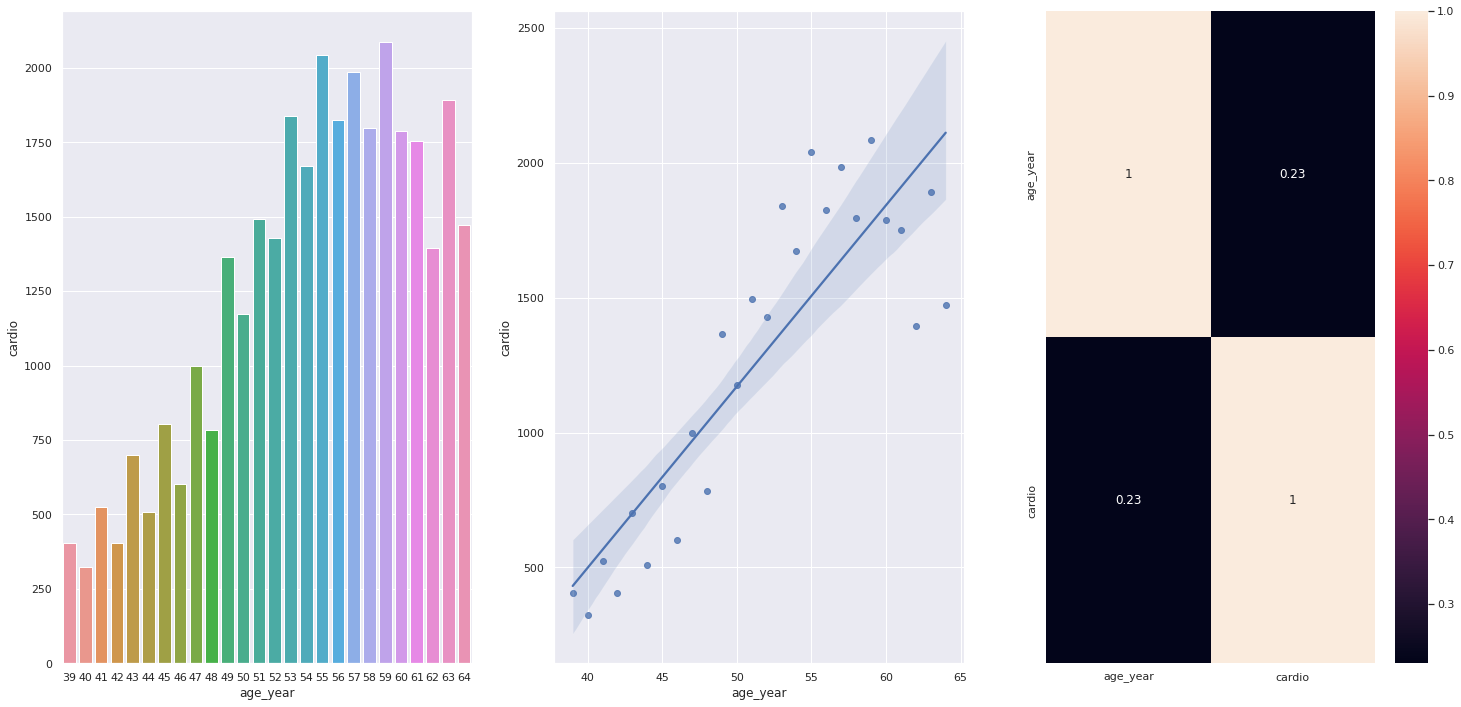

In [41]:
aux1 = df4[df4['cardio'] == 1]
aux2 = aux1[['age_year','cardio','age_range']].groupby(["age_year",'age_range']).count().reset_index()

#plot 1 - age x cardio (bar plot)
plt.subplot(1,3,1)
sns.barplot(x = 'age_year', y = 'cardio', data = aux2)

#plot2 - age x cardio (regression plot)
plt.subplot(1,3,2)
sns.regplot(x = 'age_year', y = 'cardio', data = aux2)

#plot3 - age x cardio (correlation plot)
plt.subplot(1,3,3)
sns.heatmap(df4[['age_year','cardio']].corr(method = 'pearson'), annot = True)

From these plots, we can get some informations:

- There is a growing trend between age and the number of people with cardiovascular disease.
- After 59 years, we can see a drop in the number of people with cardiovascular disease.
- The "age" variable has a low correlation with our target variable.

### H2. The presence of cardiovascular diseases will not depend directly on gender.
**False** There are twice as many cases of cardiovascular disease in people with gender equal 1.

/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'People who have cardiovascular diseases')

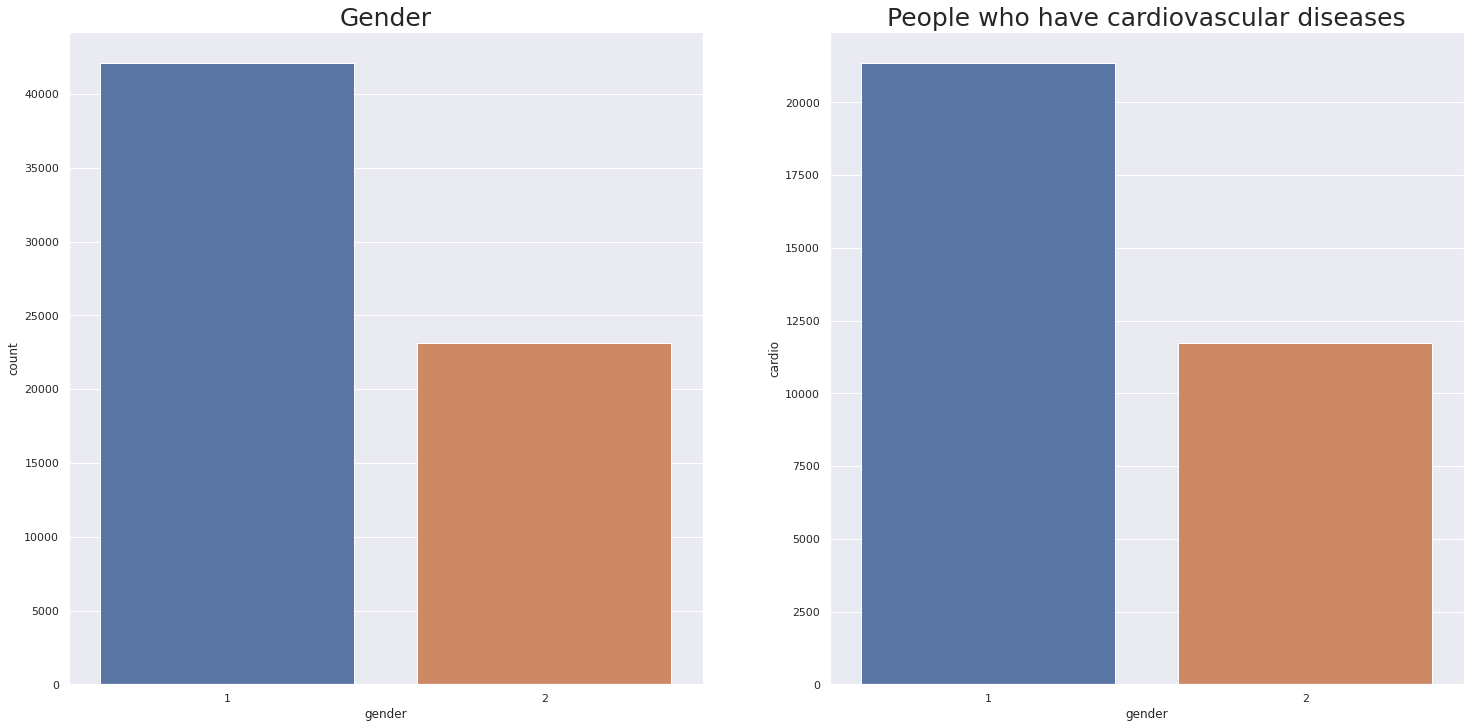

In [42]:
aux1 = df4[df4['cardio'] == 1]
aux2 = aux1[['gender','cardio']].groupby("gender").count().reset_index()

plt.subplot(1,2,1)
sns.countplot(df4['gender'])
plt.title("Gender",fontsize = 25)

#plot2 - gender x cardio (bar plot)
plt.subplot(1,2,2)
sns.barplot(x = 'gender', y = 'cardio', data = aux2)
plt.title("People who have cardiovascular diseases", fontsize = 25)

### H3. There are more cases of cardiovascular disease in people with high diastolic and systolic pressure.
**True** Although the number of people with hypertension is higher, there are more cases of people with normal blood pressure than with high blood pressure.

Text(0.5, 1.0, 'Blood Pressure x CVD')

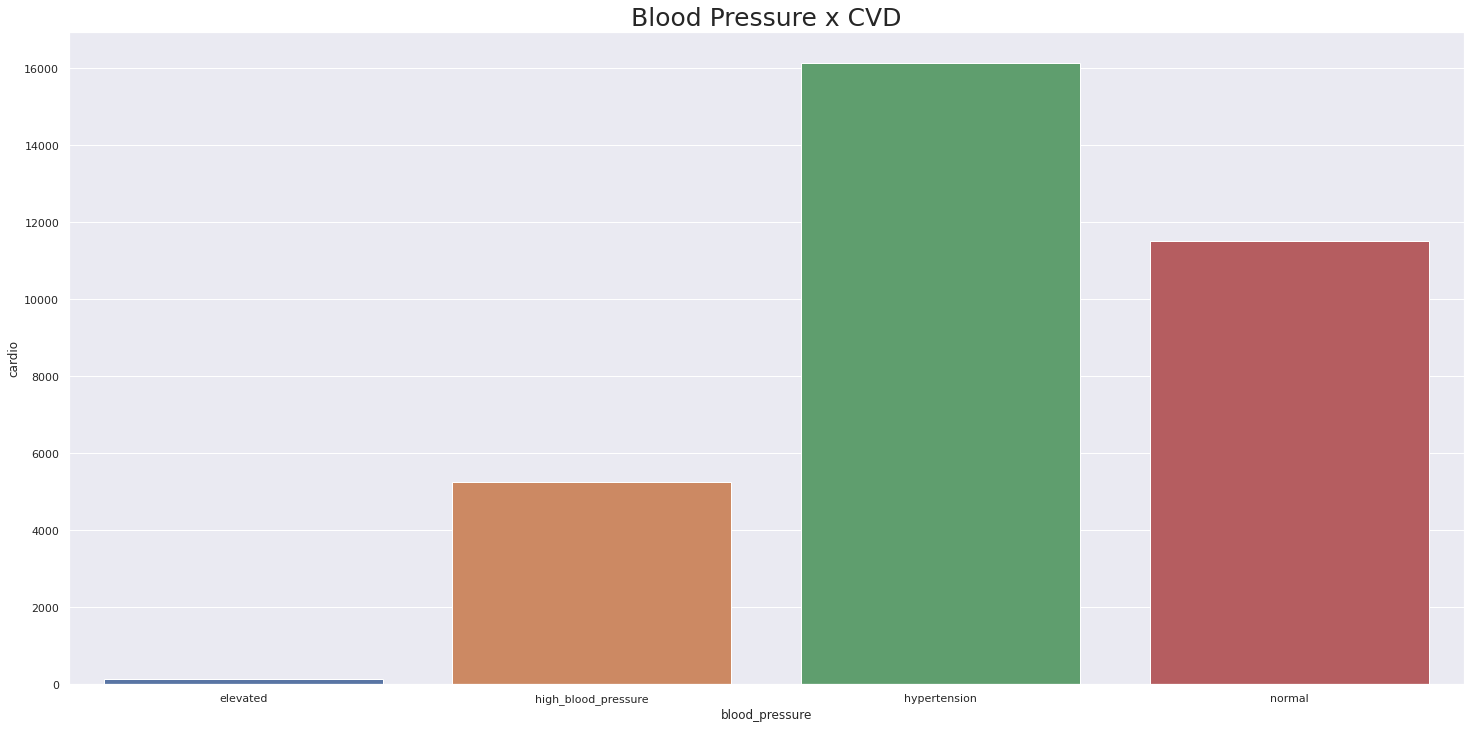

In [43]:
#filtering peoples with cardiovascular diseases
aux1 = df4[df4['cardio'] == 1]
aux2 = aux1[['blood_pressure','cardio']].groupby('blood_pressure').count().reset_index()

aux3 = aux1[['ap_hi','cardio']].groupby("ap_hi").count().reset_index()
aux4 = aux1[['ap_lo','cardio']].groupby("ap_lo").count().reset_index()

#plot1 - blood_pressure x Cardio (barplot)
sns.barplot(x = 'blood_pressure', y = 'cardio', data = aux2)
plt.title("Blood Pressure x CVD", fontsize = 25)

Text(0.5, 1.0, 'cardio x ap_lo correlation heatmap')

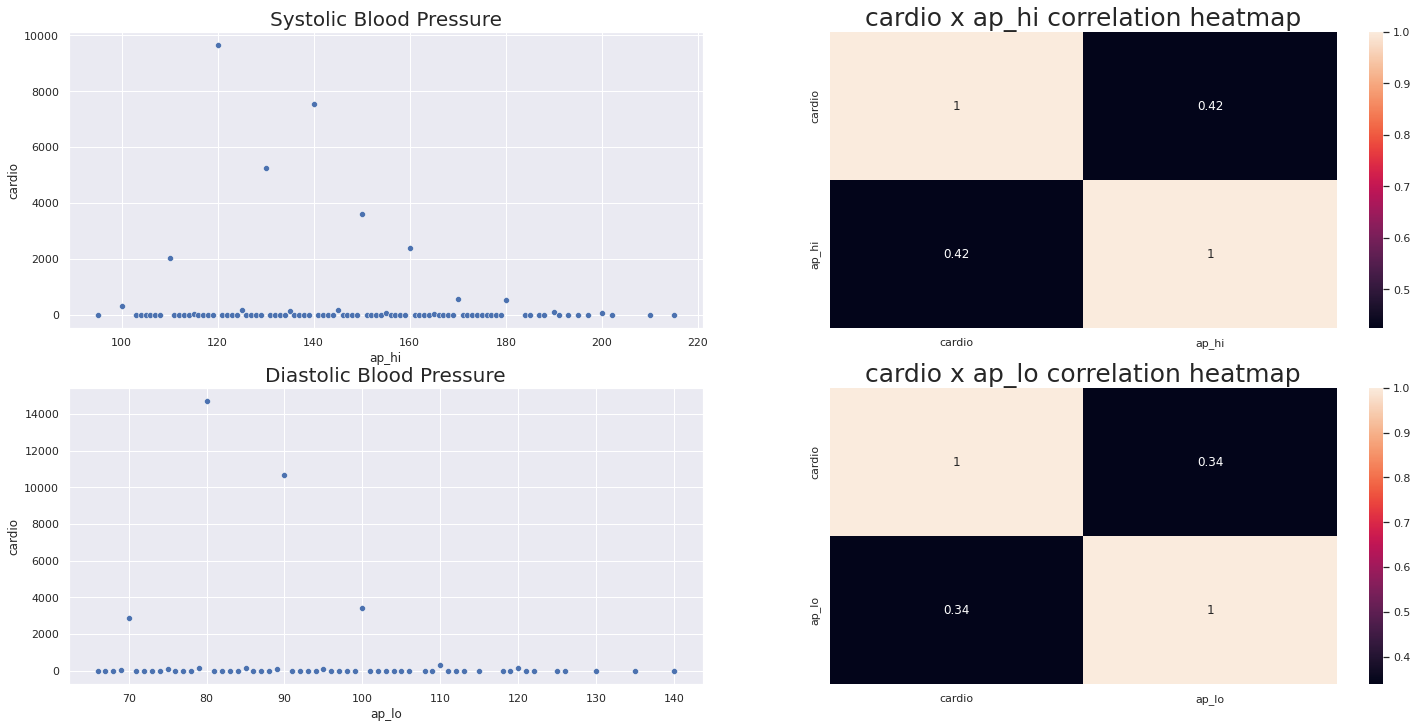

In [44]:
#plo1 - systolic blood pressure x cardio (scatterplot/dipersion plot)
plt.subplot(2,2,1)
sns.scatterplot(x = 'ap_hi', y  = 'cardio', data = aux3)
plt.title("Systolic Blood Pressure", fontsize = 20)

#plot2 - check the correlation between binary variables(cardio) and continuous variables(ap_hi) (point biseral)
plt.subplot(2,2,2)
point_bi(df4[['cardio']],df4[['ap_hi']])
 
#plot3 - diastolic blood pressure x cardio (scatterplot / dispersion plot)    
plt.subplot(2,2,3)
sns.scatterplot(x = 'ap_lo', y  = 'cardio', data = aux4)
plt.title("Diastolic Blood Pressure", fontsize = 20)

#plot4 - check the correlatio between binary variables(cardio) and continuous variables(ap_lo) (point biseral)
plt.subplot(2,2,4)
point_bi(df4[['cardio']],df4[['ap_lo']])

What can we get about the plots above?

- There are many people with hypertension and cardiovascular disease. However, there are also a lot of people without hypertension and with cardiovascular disease.
- In scatterplots, we can see some points with a very high number of cases of cardiovascular diseases. For example, there are almost 10,000 people with 120mmHg of systolic blood pressure with CVD.
- In both types of blood pressure, we have a positive correlation with our target variable. Systolic blood pressure has a moderate correlation and diastolic blood, a weak correlation.

### H4. There are more cases of cardiovascular disease in people who smoke.
**False** There are more cases in people who don't smoke.

/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'CVD x Smoke')

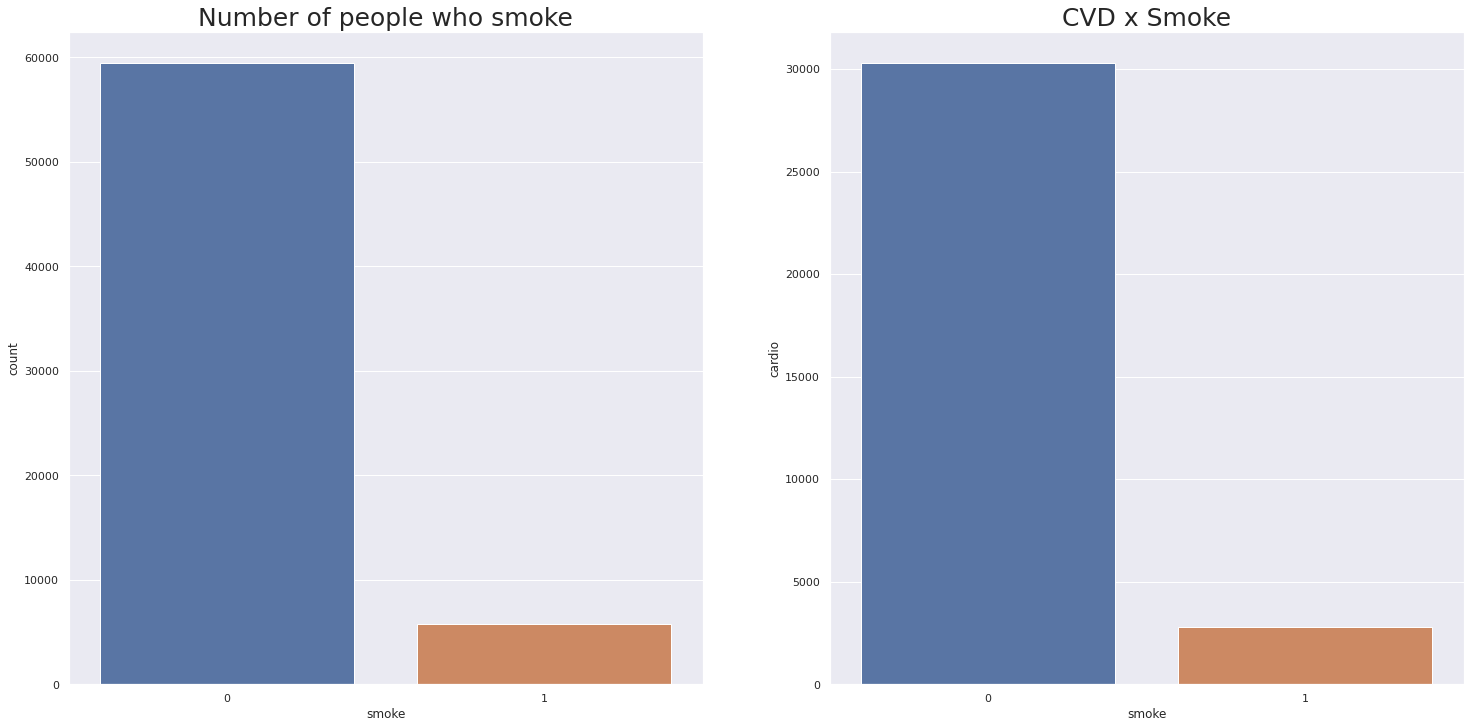

In [45]:
aux1 = df4[df4['cardio'] == 1]
aux2 = aux1[['smoke','cardio']].groupby("smoke").count().reset_index()

#plot1 - countplot to our smoke variable
plt.subplot(1,2,1)
sns.countplot(df4['smoke'])
plt.title("Number of people who smoke",fontsize = 25)

#plot2 - Cvd x Smoke (barplot)
plt.subplot(1,2,2)
sns.barplot(x = 'smoke', y = 'cardio', data = aux2)
plt.title("CVD x Smoke", fontsize = 25)

From these plots, we can get some informations:

- The number of people who do not smoke is much greater than those who smoke.
- The number of people who do not smoke and have cardiovascular disease is much greater than those who smoke.
- The explanation of the second point described above, perhaps can be explained by the first point. We can't be sure.

### H5. There are more cases of cardiovascular disease in people who drink alcoholic beverages
**False** There are more cases in people who don't drink alcohol beverages.

/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Alcohol and Cardio')

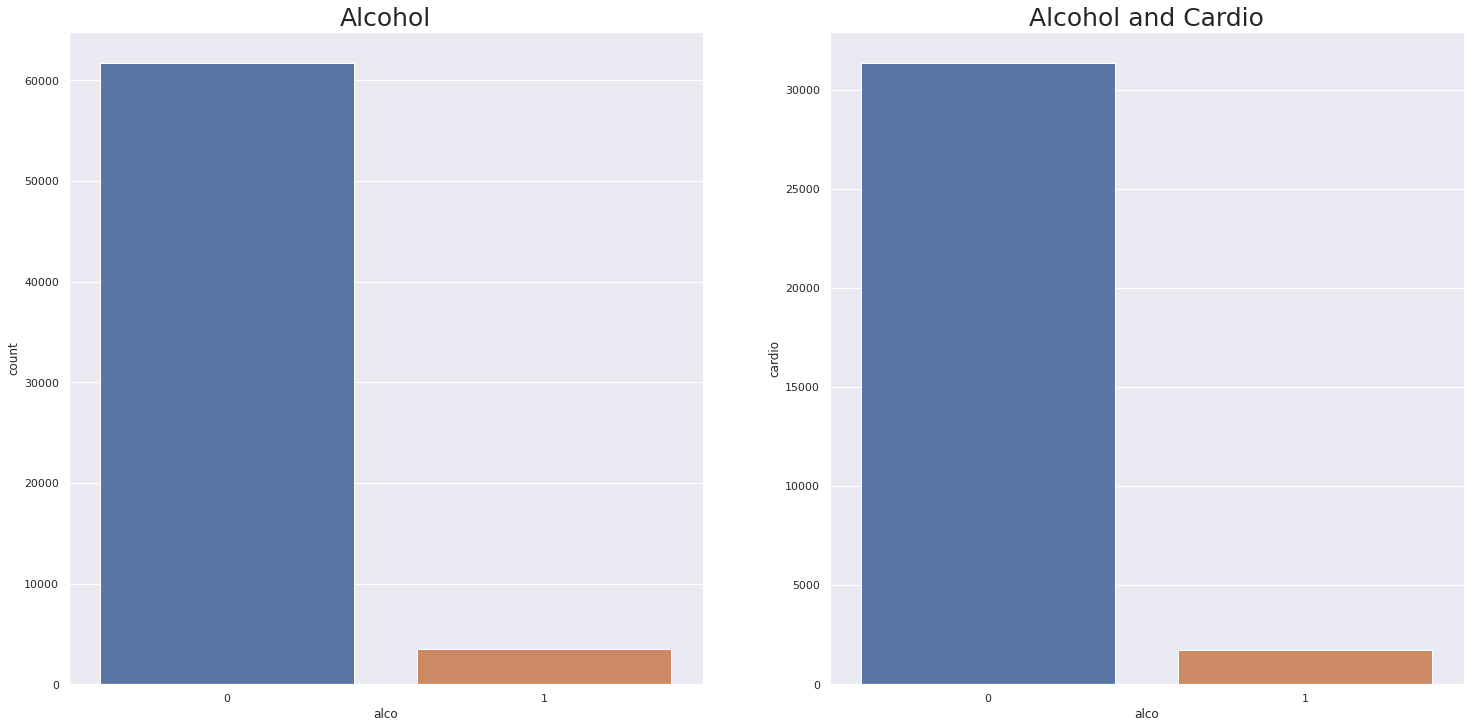

In [46]:
aux1 = df4[df4['cardio'] == 1]
aux2 = aux1[['alco','cardio']].groupby("alco").count().reset_index()

#plo1 - countplot to our alcohol variable 
plt.subplot(1,2,1)
sns.countplot(df4['alco'])
plt.title("Alcohol", fontsize = 25)

#plot2 - alcohol x cardio (barplot)
plt.subplot(1,2,2)
sns.barplot(x = 'alco', y = 'cardio', data = aux2)
plt.title("Alcohol and Cardio",fontsize = 25)

From these plots above, we can get some informations:

- The number of people who do not consume alcoholic beverages is much greater than those who do.
- The number of people who do not consume alcoholic beverages and who have cardiovascular disease is much greater than the people who consume alcoholic beverages.

### H6. There are more cases of cardiovascular disease in people who are overweight.
**True** However, the number of cases in obese people is less than the number of cases of people with normal weight. The number of extremely obese people with cardiovascular disease is almost half the number of people with a normal person.

Text(0.5, 1.0, 'cardio x bmi correlation heatmap')

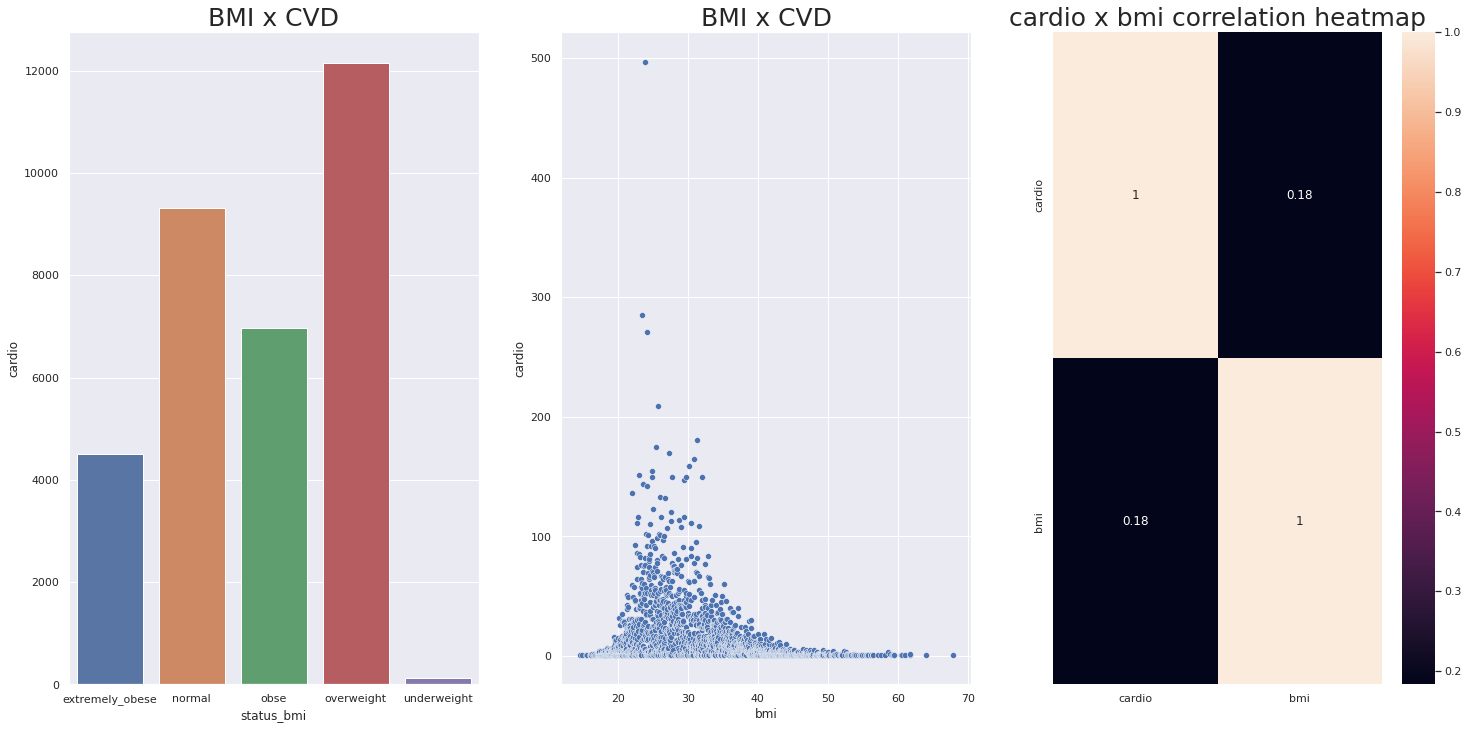

In [47]:
aux1 = df4[df4['cardio'] == 1]
aux2 = aux1[['status_bmi','cardio']].groupby("status_bmi").count().reset_index()
aux3 = aux1[['bmi','cardio']].groupby("bmi").count().reset_index()

#plot1 - BMI X CARDIO (BARPLOT)
plt.subplot(1,3,1)
sns.barplot(x = 'status_bmi', y = 'cardio', data = aux2)
plt.title("BMI x CVD",fontsize = 25)

#plot2 - BMI X CVD (SCATTERPLOT/DISPERSION PLOT)
plt.subplot(1,3,2)
sns.scatterplot(x = 'bmi', y = 'cardio', data = aux3)
plt.title("BMI x CVD",fontsize = 25)

#plot3 - Correlation between binary variable(cardio) and continuous variable(bmi) using point biseral.
plt.subplot(1,3,3)
point_bi(df4[['cardio']], df4[['bmi']])

- The number of cases in obese people is less than the number of cases of people with normal weight. 
- The number of extremely obese people with cardiovascular disease is almost half the number of people with a normal person.
- There's a low positive correlation between bmi and cardio

### H7. There are fewer cases of cardiovascular disease in people who practice physical activity
**True** There are more cases of cardiovascular diseases in people who don't practice physical activity.

<AxesSubplot:xlabel='active', ylabel='count'>

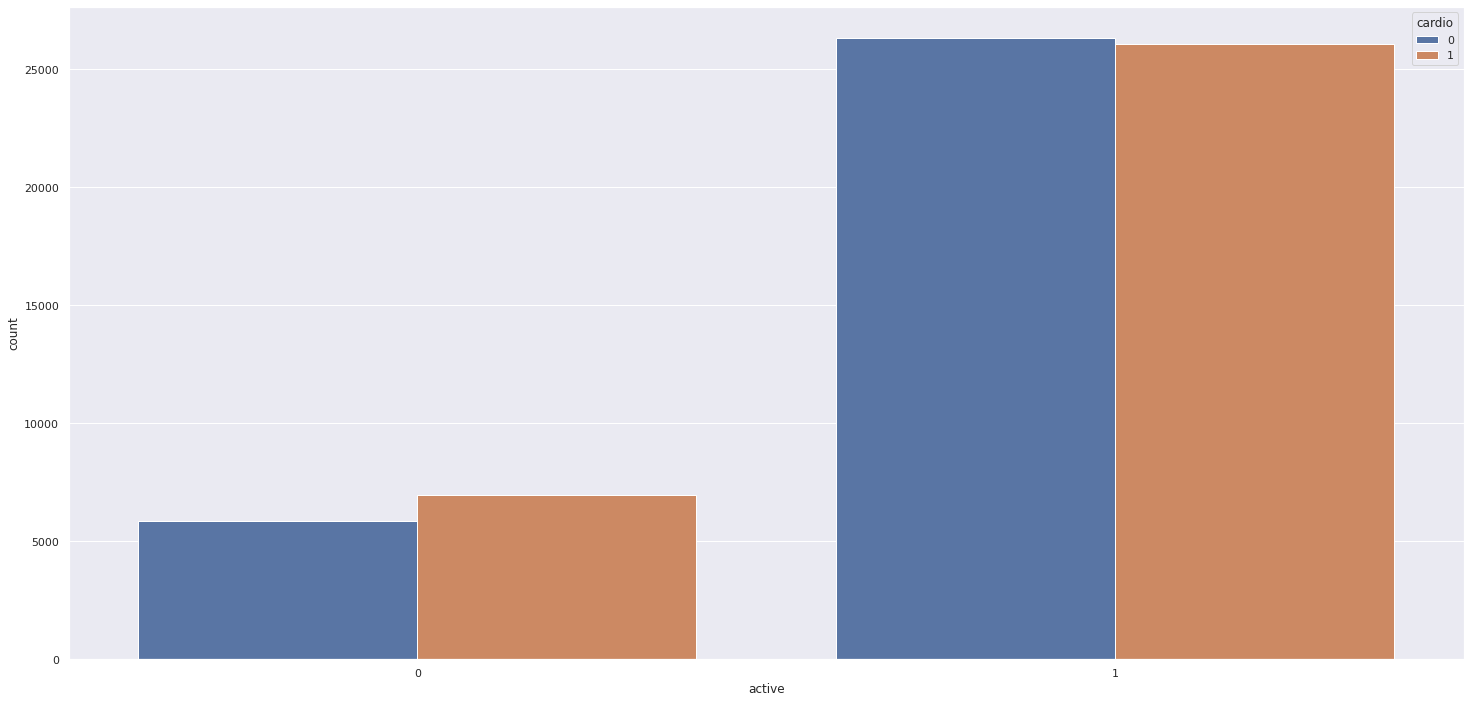

In [48]:
#plot - countplot to our active variable
sns.countplot(x = 'active', hue = 'cardio', data = df4)

About the plots above, we can notice some points:

- For people who do not practice physical activity, there is a greater number of cardiovascular diseases.
- For people who practice physical activity, there are fewer people with cardiovascular disease.

### H8. There are more cases of cardiovascular disease in people who have a high glucose rate.
**True** There are more cases of cardiovascular diseases in people who have a high glucose rate.

<AxesSubplot:xlabel='gluc', ylabel='count'>

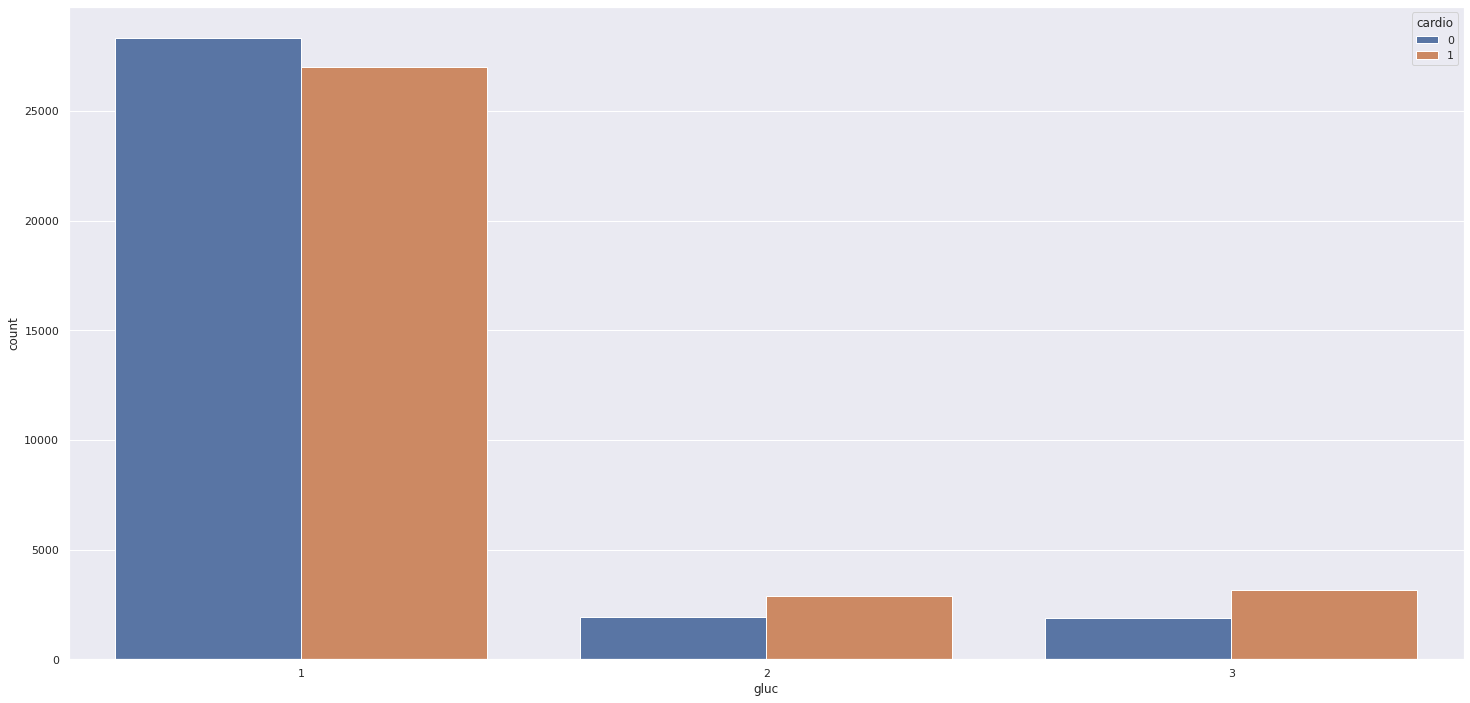

In [49]:
#plot - Compare glucose level with the presence of CVD.
sns.countplot(x = 'gluc', hue = 'cardio', data = df4)

- There are more cases of cardiovascular diseases in people who have a high glucose rate.
- There are many more people with normal glucose levels, but a high number of people with CVD.

### H9. There is a incresed risk of cardiovascular disease if your cholesterol is above normal.
**True** There are more cases of cardiovascular diseases in people who have high cholesterol

<AxesSubplot:xlabel='cholesterol', ylabel='count'>

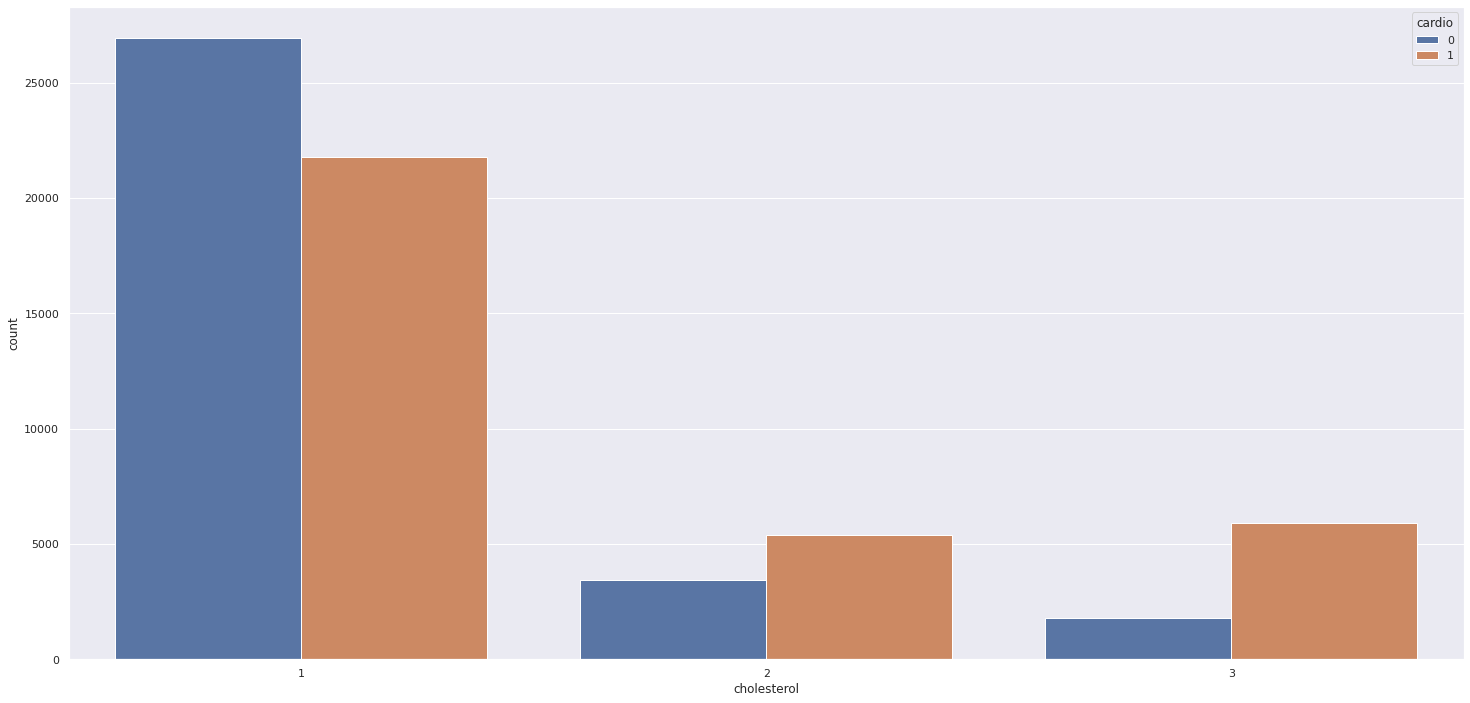

In [50]:
sns.countplot(x = 'cholesterol', hue = 'cardio', data = df4)

From these plots we can get some informations:

- There is a high number of people with a normal cholesterol level but with the presence of cardiovascular diseases. Although the quantity is smaller, it is a high number that needs to be observed.
- The level of people with high cholesterol who have CVD is higher than those who are not.

### 4.2.2 Summary of Hypotheses

In [51]:
tab = [['Hypotheses', 'Conclusion', 'Relevance'],
       ['H1', 'True', 'Medium'],
       ['H2', 'False', 'Low'],
       ['H3', 'True', 'High'],
       ['H4', 'False', 'Low'],
       ['H5', 'False', 'Low'],
       ['H6', 'True', 'High'],
       ['H7', 'False', 'Medium'],
       ['H8', 'True', 'Medium'],
       ['H9', 'True', 'High']]

print(tabulate(tab, headers = 'firstrow'))

Hypotheses    Conclusion    Relevance
------------  ------------  -----------
H1            True          Medium
H2            False         Low
H3            True          High
H4            False         Low
H5            False         Low
H6            True          High
H7            False         Medium
H8            True          Medium
H9            True          High


## 4.3. Multivariate Analysis

<AxesSubplot:>

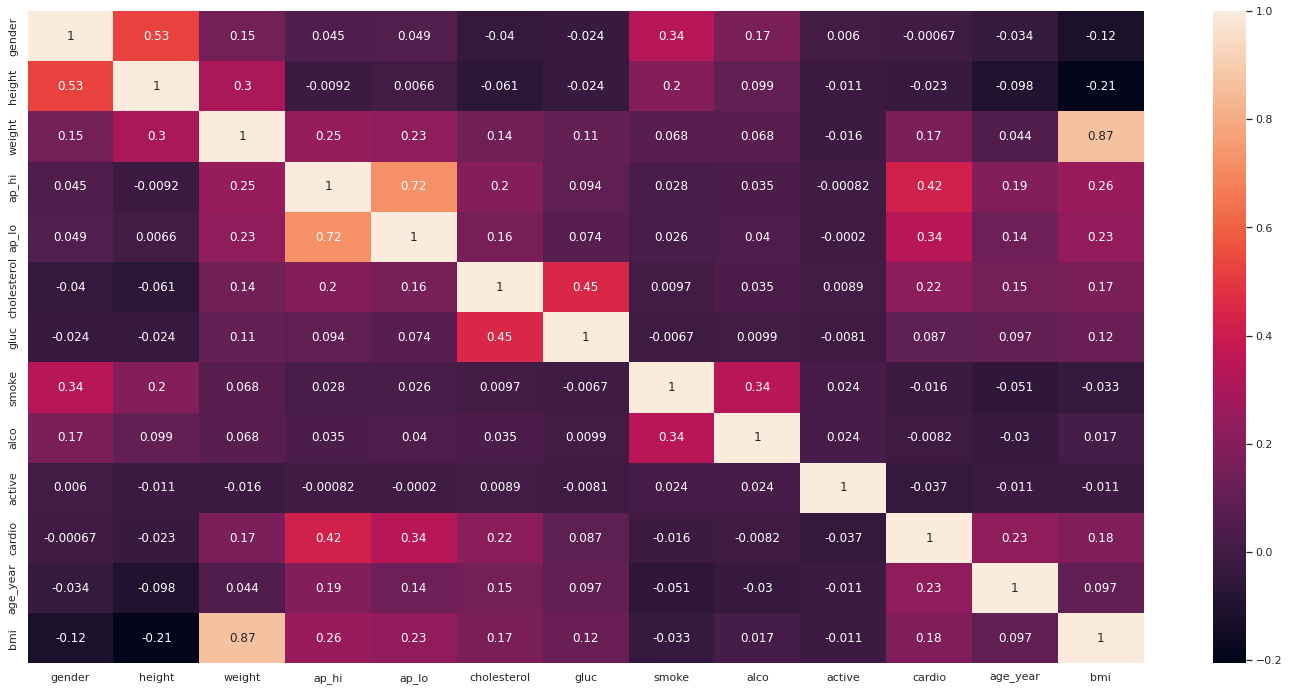

In [52]:
#exclude numerical variables
aux1 = df4.select_dtypes(exclude = ['object'])

#plot correlation plot to our numerical variables.
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

# 5.0. BALANCED DATASET

In [53]:
df5 = df4.copy()

## 5.1. Random Undersampling

In [54]:
#define sampler
undersampling = us.RandomUnderSampler(sampling_strategy = "majority", random_state = 32)


#apply sampler
x_under, y_under = undersampling.fit_resample(df5 , df5['cardio'])

In [55]:
df5['cardio'].value_counts()

1    33066
0    32170
Name: cardio, dtype: int64

In [56]:
y_under.value_counts()

0    32170
1    32170
Name: cardio, dtype: int64

## 5.2. Random Oversampling

In [57]:
#define sampler
oversampling = oversamp.RandomOverSampler(sampling_strategy = 'minority', random_state = 32)

#apply sampler
x_over, y_over = oversampling.fit_resample(df5 , df5['cardio'])

In [58]:
df5['cardio'].value_counts()

1    33066
0    32170
Name: cardio, dtype: int64

In [59]:
y_over.value_counts()

0    33066
1    33066
Name: cardio, dtype: int64

## 5.3. SMOTE + TOMEKLINK

### Encoding

In [60]:
#blood_pressure - OrdinalEncoding
dict_blood = {'normal':1, 'elevated':2,'high_blood_pressure':3, 'hypertension':4}
df5['blood_pressure'] = df5['blood_pressure'].map(dict_blood)

#status_bmi - OrdinalEncoding
dict_bmi = {'underweight':1,'normal':2,'overweight':3,'obse':4,'extremely_obese':5}
df5['status_bmi'] = df5['status_bmi'].map(dict_bmi)

#age_range - OrdinalEncoding
dict_age_range = {'50-65':2,'0-50':1}
df5['age_range'] = df5['age_range'].map(dict_age_range)

#gender - OneHotEncoding
df5['gender_01'] = df5['gender'].apply(lambda x: 1 if x == 1 else 0)
df5['gender_02'] = df5['gender'].apply(lambda x: 1 if x == 2 else 0 )

In [61]:
#define sampler
smt = c.SMOTETomek(sampling_strategy = 'auto', random_state = 32, n_jobs = -1)

#apply sampler
x_smt, y_smt = smt.fit_resample(df5, df5['cardio'])

In [62]:
pickle.dump(smt, open("./parameters/smt.pkl", "wb"))

In [63]:
y_smt.value_counts()

0    29509
1    29509
Name: cardio, dtype: int64

As we see above, we got our classes completely balanced.

In [65]:
#join target variable
df_smt = x_smt
df_smt['cardio'] = y_smt
df_smt.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_year,blood_pressure,bmi,status_bmi,age_range,gender_01,gender_02
0,2,168,62.0,110,80,1,1,0,0,1,0,50,1,21.97,2,1,0,1
1,1,156,85.0,140,90,3,1,0,0,1,1,55,4,34.93,5,2,1,0
2,2,169,82.0,150,100,1,1,0,0,1,1,48,4,28.71,3,1,0,1
3,1,151,67.0,120,80,2,2,0,0,0,0,60,1,29.38,3,2,1,0
4,2,178,95.0,130,90,3,3,0,0,1,1,61,3,29.98,5,2,0,1


In [66]:
#Re-encoding
#blood_pressure - OrdinalEncoding
dict_blood = {1:'normal',2:'elevated',3:'high_blood_pressure',4:'hypertension'}
df_smt['blood_pressure'] = df_smt['blood_pressure'].map(dict_blood)

#status_bmi - OrdinalEncoding
dict_bmi = {1:'underweight',2:'normal',3:'overweight',4:'obse',5:'extremely_obese'}
df_smt['status_bmi'] = df_smt['status_bmi'].map(dict_bmi)

#age_range - OrdinalEncoding
dict_age_range = {2:'50-65',1:'0-50'}
df_smt['age_range'] = df_smt['age_range'].map(dict_age_range)

#gender - OneHotEncoding
df_smt.drop(columns = ['gender_01','gender_02'],axis = 1, inplace = True)

In [67]:
df_smt.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_year,blood_pressure,bmi,status_bmi,age_range
0,2,168,62.0,110,80,1,1,0,0,1,0,50,normal,21.97,normal,0-50
1,1,156,85.0,140,90,3,1,0,0,1,1,55,hypertension,34.93,extremely_obese,50-65
2,2,169,82.0,150,100,1,1,0,0,1,1,48,hypertension,28.71,overweight,0-50
3,1,151,67.0,120,80,2,2,0,0,0,0,60,normal,29.38,overweight,50-65
4,2,178,95.0,130,90,3,3,0,0,1,1,61,high_blood_pressure,29.98,extremely_obese,50-65


# 6.0. DATA PREPARATION

In [68]:
#making a copy of data
df6 = df_smt.copy()

## 6.1. Split dataframe into training and test dataset

The train-test split procedure is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model.
It is procedure to perform, the results of which allow you to compare the performance of machine learning algorithms for your predictive modeling problem. 

In [69]:
#split data
X = df6.drop(['cardio',], axis = 1).copy()
y = df6['cardio']

#split data into training and test dataset
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.20, random_state = 42)

## 6.2. Normalization

If the population mean and population standard deviation are known, a raw score x is converted into a standard score by

<AxesSubplot:xlabel='bmi', ylabel='Count'>

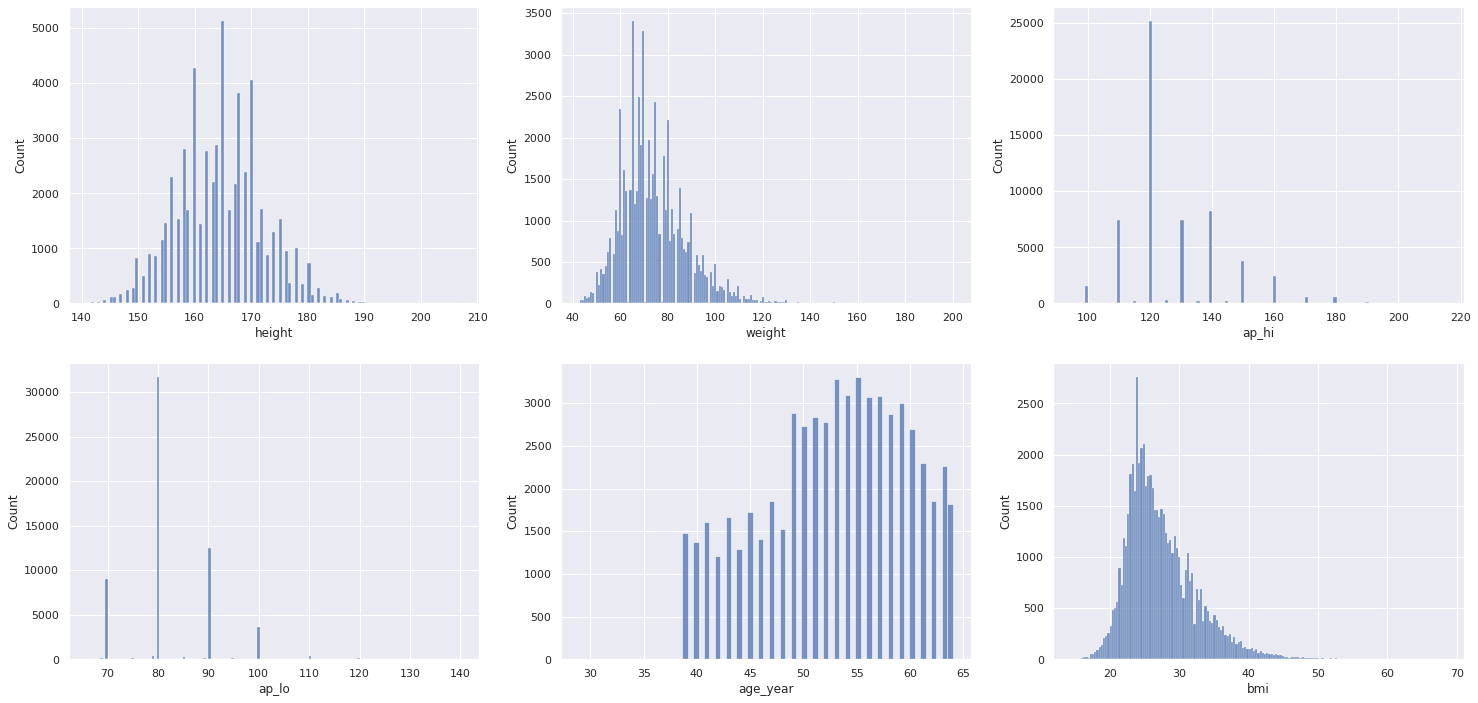

In [71]:
#height
plt.subplot(2,3,1)
sns.histplot(df6['height'])

#weight
plt.subplot(2,3,2)
sns.histplot(df6['weight'])

#ap_hi
plt.subplot(2,3,3)
sns.histplot(df6['ap_hi'])

#ap_lo
plt.subplot(2,3,4)
sns.histplot(df6['ap_lo'])

#age_year
plt.subplot(2,3,5)
sns.histplot(df6['age_year'])

#bmi
plt.subplot(2,3,6)
sns.histplot(df6['bmi'])

- bmi -> It has a distribution close to normal.
- weight -> It has a distribution close to normal, but with some oscillations.

## 6.3. Rescaling

In this step, we will perform the rescaling of our numerical variables. For this, we need to check the presence of outliers in order to choose the best technique for our model. The techniques that will be used:

- RobustScaler -> Robust in the presence of outliers, therefore, in the variables that have a significant amount of outliers we will apply this technique.

- MinMaxScaler -> Sensitive in the presence of outliers, therefore, we will apply to our variables that do not have outliers.

/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result

<AxesSubplot:xlabel='bmi', ylabel='Density'>

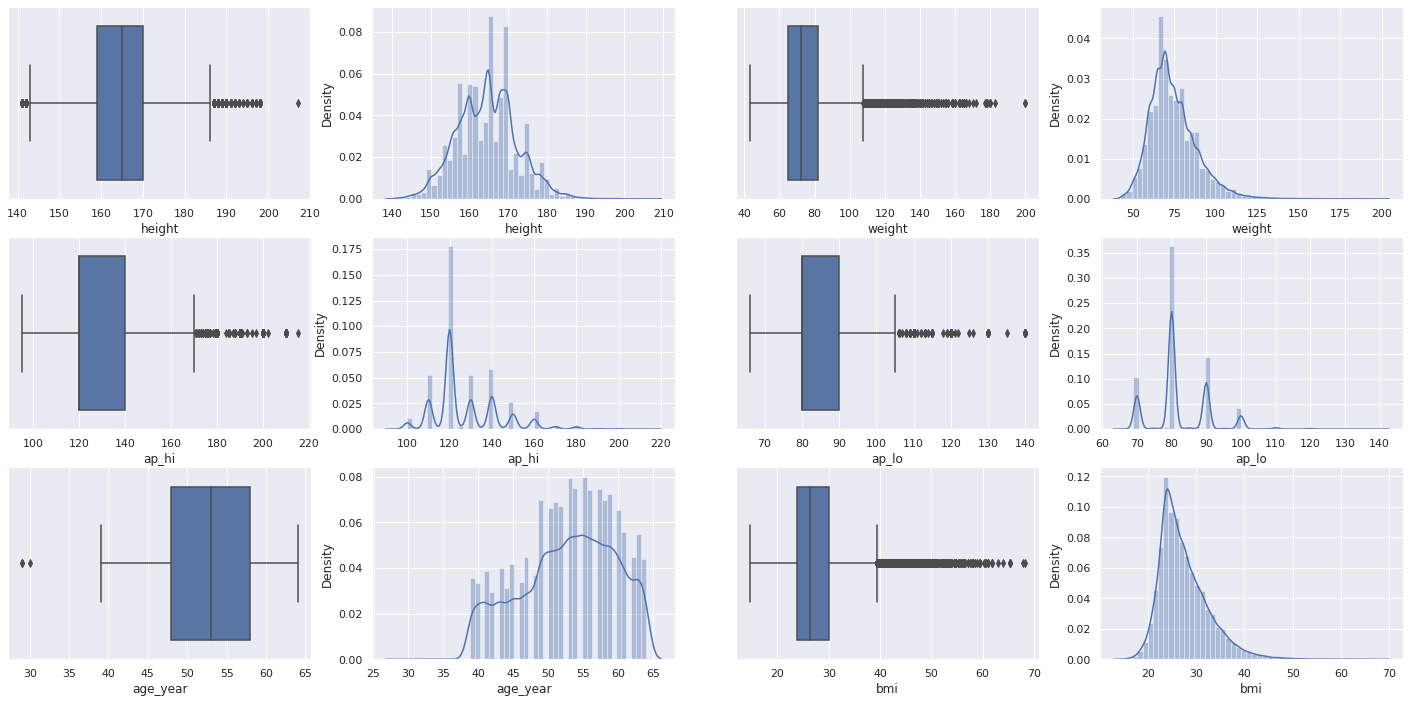

In [72]:
#height
plt.subplot(3,4,1)
sns.boxplot(df6['height'])

plt.subplot(3,4,2)
sns.distplot(df6['height'])

#weight
plt.subplot(3,4,3)
sns.boxplot(df6['weight'])

plt.subplot(3,4,4)
sns.distplot(df6['weight'])

#ap_hi
plt.subplot(3,4,5)
sns.boxplot(df6['ap_hi'])

plt.subplot(3,4,6)
sns.distplot(df6['ap_hi'])

#ap_lo
plt.subplot(3,4,7)
sns.boxplot(df6['ap_lo'])

plt.subplot(3,4,8)
sns.distplot(df6['ap_lo'])

#age_year
plt.subplot(3,4,9)
sns.boxplot(df6['age_year'])

plt.subplot(3,4,10)
sns.distplot(df6['age_year'])

#bmi
plt.subplot(3,4,11)
sns.boxplot(df6['bmi'])

plt.subplot(3,4,12)
sns.distplot(df6['bmi'])

- RobustScaler 
    - ap_lo
    - ap_hi
    - bmi 
    - Weight

- MinMaxScaler 
    - age_year
    - height

In [73]:
rs = RobustScaler() #RobustScaler
mms = MinMaxScaler() #MinMaxScaler

#ap_lo - RobustScaler
X_train['ap_lo'] = rs.fit_transform(X_train[['ap_lo']].values)
X_test['ap_lo'] = rs.fit_transform(X_test[['ap_lo']].values)
pickle.dump(rs, open("./parameters/rescaling_ap_lo.pkl","wb"))

#ap_hi - RobustScaler
X_train['ap_hi'] = rs.fit_transform(X_train[['ap_hi']].values)
X_test['ap_hi'] = rs.fit_transform(X_test[['ap_hi']].values)
pickle.dump(rs, open("./parameters/rescaling_ap_hi.pkl","wb"))

#weight - RobustScaler
X_train['weight'] = rs.fit_transform(X_train[['weight']].values)
X_test['weight'] = rs.fit_transform(X_test[['weight']].values)
pickle.dump(rs, open("./parameters/rescaling_weight.pkl","wb"))

#bmi - RobustScaler
X_train['bmi'] = rs.fit_transform(X_train[['bmi']].values)
X_test['bmi'] = rs.fit_transform(X_test[['bmi']].values)
pickle.dump(rs, open("./parameters/rescaling_bmi.pkl","wb"))

#age_year - MinMaxScaler
X_train['age_year'] = mms.fit_transform(X_train[['age_year']].values)
X_test['age_year'] = mms.fit_transform(X_test[['age_year']].values)
pickle.dump(mms, open("./parameters/rescaling_age_year.pkl","wb"))

#height - MinMaxScaler 
X_train['height'] = mms.fit_transform(X_train[['height']].values)
X_test['height'] = mms.fit_transform(X_test[['height']].values)
pickle.dump(mms, open("./parameters/rescaling_height.pkl","wb"))

## 6.4. Transformation

### Encoding

In [74]:
#blood_pressure - OrdinalEncoding
dict_blood = {'normal':1, 'elevated':2,'high_blood_pressure':3, 'hypertension':4}
X_train['blood_pressure'] = X_train['blood_pressure'].map(dict_blood)
X_test['blood_pressure'] = X_test['blood_pressure'].map(dict_blood)

#status_bmi - OrdinalEncoding
dict_bmi = {'underweight':1,'normal':2,'overweight':3,'obse':4,'extremely_obese':5}
X_train['status_bmi'] = X_train['status_bmi'].map(dict_bmi)
X_test['status_bmi'] = X_test['status_bmi'].map(dict_bmi)

#age_range - OrdinalEncoding
dict_age_range = {'50-65':2,'0-50':1}
X_train['age_range'] = X_train['age_range'].map(dict_age_range)
X_test['age_range'] = X_test['age_range'].map(dict_age_range)

#gender - OneHotEncoding
X_train['gender_01'] = X_train['gender'].apply(lambda x: 1 if x == 1 else 0)
X_train['gender_02'] = X_train['gender'].apply(lambda x: 1 if x == 2 else 0 )
X_test['gender_01'] = X_test['gender'].apply(lambda x: 1 if x == 1 else 0)
X_test['gender_02'] = X_test['gender'].apply(lambda x: 1 if x == 2 else 0 )

In [75]:
X_train.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_year,blood_pressure,bmi,status_bmi,age_range,gender_01,gender_02
36580,2,0.272727,0.764706,0.0,0.0,2,2,0,0,0,0.885714,1,1.178744,4,2,0,1
31436,2,0.500000,1.000000,1.5,2.0,2,2,0,1,1,0.685714,4,0.499195,3,2,0,1
28627,2,0.575758,1.117647,-0.5,0.0,3,3,0,0,0,0.971429,1,0.338164,3,2,0,1
6529,2,0.287879,-0.823529,0.0,0.0,1,1,1,0,1,0.771429,1,-0.586151,2,2,0,1
22529,2,0.560606,0.470588,0.0,0.0,1,1,0,0,0,0.285714,1,-0.169082,3,1,0,1


# 7.0. FEATURE SELECTION

In [76]:
df6 = df5.copy()

## 7.1. Boruta as Feature Selector

The Boruta algorithm is a wrapper built around the random forest classification algorithm. It tries to capture all the important, interesting features you might have in your dataset with respect to an outcome variable.

In [77]:
#define model
xgb_model = xgb.XGBClassifier(n_jobs=-1)
extra_model = ExtraTreesClassifier(n_jobs=-1)
rf_model = RandomForestClassifier(n_jobs = -1)

#split data 
X_train_nn = X_train.values
y_train_nn = y_train.values.ravel()

#define boruta
boruta = BorutaPy(extra_model, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_nn, y_train_nn)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	10
Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	10
Iteration: 	10 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	10
Iteration: 	11 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	10
Iteration: 	12 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	11
Iteration: 	13 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	11
Iteration: 	14 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	11
Iteration: 	15 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	11
Iteration: 	16 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	11
I

In [78]:
#best features from boruta
cols_selected = boruta.support_.tolist()
cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['weight', 'ap_hi', 'age_year', 'blood_pressure', 'bmi']

Fetures Selected From boruta

- ap_hi 
- age_year
- blood_pressure
- bmi

Obtaining the features selected by boruta, we will compare it with our relevance table that was built in the "Exploratory Data Analysis".



## 7.2. Manual Feature Selection

Although the best feature from boruta, we will based on our understanding of the business and add other variables.Therefore, although the algorithm is extremely important for selecting features, it does not nullify our opinion about the problem we are working on.

In [79]:
#features that will be really important to our model
cols_selected_boruta_full = ['ap_hi','ap_lo','age_year','weight','height','blood_pressure','bmi','cholesterol']

In [80]:
#creating a dataframe with selected columns
X_train_boruta = X_train[cols_selected_boruta_full].copy()
X_test_boruta = X_test[cols_selected_boruta_full].copy()

<AxesSubplot:>

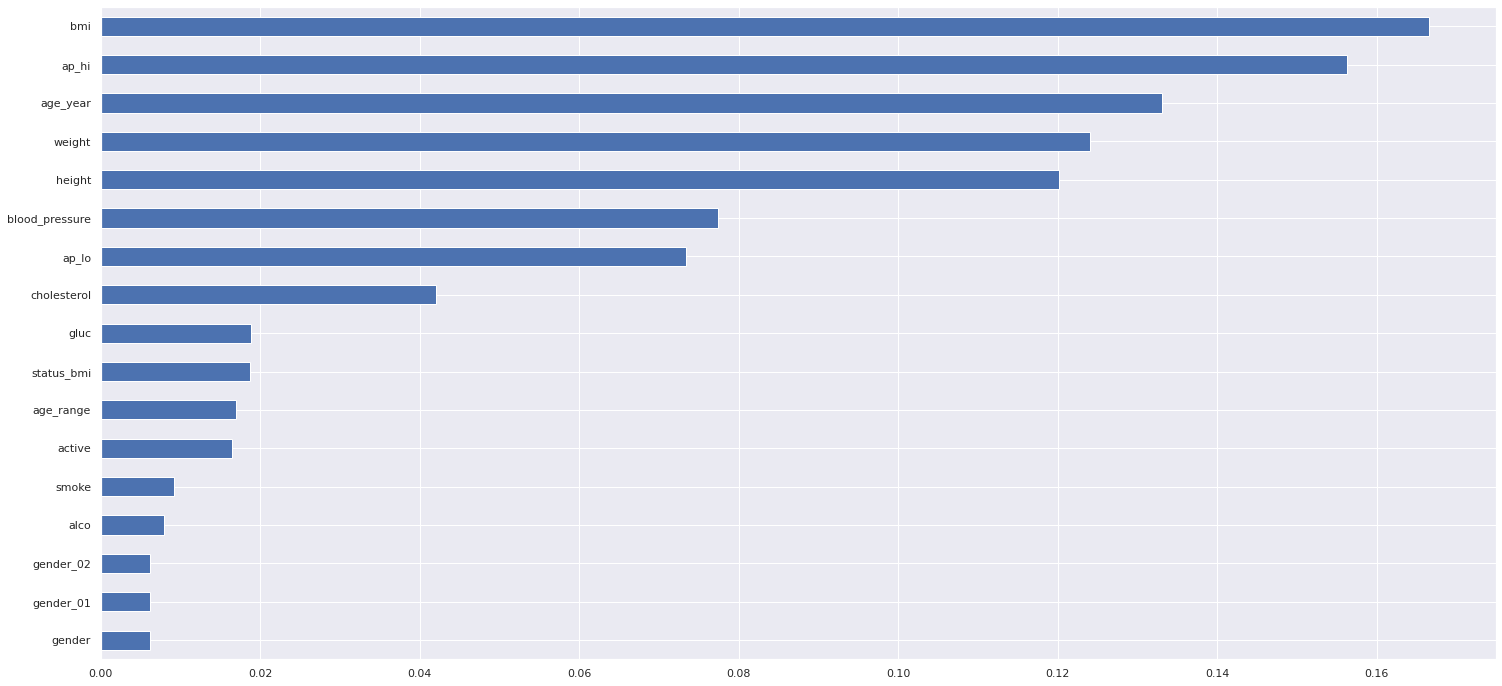

In [81]:
#feature importances 
rf_model = RandomForestClassifier(n_jobs = -1)
rf_model.fit(X_train, y_train)

feat_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind='barh')

# 8.0. MACHINE LEARNING MODELLING

In this section, we will finally build our predictive models. Therefore, we will use 5 machine learning algorithms, which will be:

- Baseline Model
- Logistic Regression
- Support Vector Machine
- XGBoost Classifier
- K-Nearest Neighbors
- LGBM Classifier
- Random Forest Classifier

For the best performing algorithm, we will build what we call the cross-validation technique. Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. So, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.

It is a popular method because it is simple to understand and because it generally results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train / test split.

For this, we will separate our predictor variables from our target variable and then separate them in training and testing.

In [82]:
#copying data
X_train = X_train_boruta.copy()
X_test = X_test_boruta.copy()

## 8.1. Baseline Model

Accuracy: 0.49220603185360895
Kappa Score: -0.015560181102925563
              precision    recall  f1-score   support

           0       0.49      0.50      0.49      5874
           1       0.49      0.49      0.49      5930

    accuracy                           0.49     11804
   macro avg       0.49      0.49      0.49     11804
weighted avg       0.49      0.49      0.49     11804



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

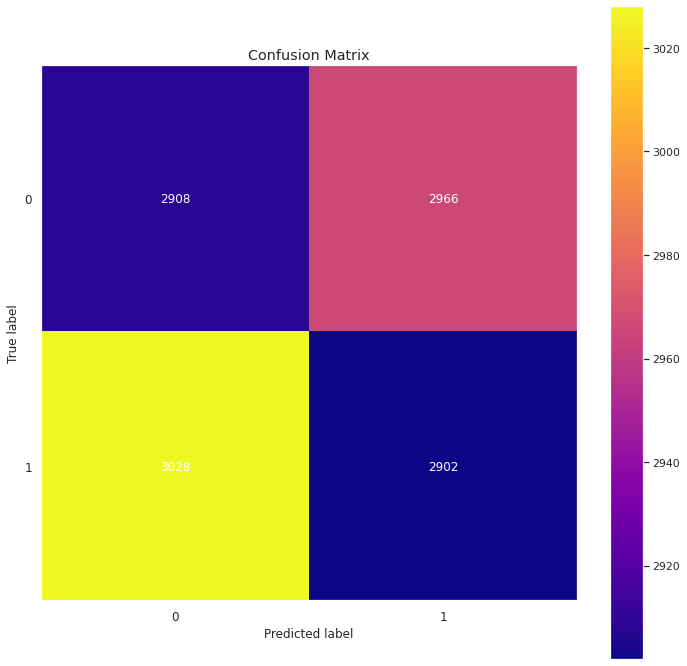

In [90]:
import random
cardio = y_test.drop_duplicates().sort_values().tolist()
random_test = X_test.shape[0]
cardio_weights = df1['cardio'].value_counts( normalize=True ).sort_index().tolist()

# prediction
yhat_random = random.choices( cardio, k=random_test,
                              weights=cardio_weights )

# Accuracy
acc_random = accuracy_score( y_test, yhat_random )
print( 'Accuracy: {}'.format( acc_random ) )

# Kappa Metrics
kappa_random = cohen_kappa_score( y_test, yhat_random )
print( 'Kappa Score: {}'.format( kappa_random ) )

# Classification report
print( classification_report( y_test, yhat_random ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat_random, normalize=False, figsize=(12,12), cmap='plasma')

## 8.2. Logistic Regression

In [91]:
#define model
logreg = LogisticRegression()

#training model
logreg.fit(X_train.values,y_train.values.ravel())

#predict
yhat_log = logreg.predict(X_test) 

# AUC-ROC
logreg_cv = cross_val_predict(logreg, X_train, y_train, cv=5, method='decision_function')
logreg_roc = roc_auc_score(y_train, logreg_cv)

#performance
result_log = pd.DataFrame(["Logistic Regression",accuracy_score(y_test,yhat_log),cohen_kappa_score(y_test,yhat_log),
                          recall_score(y_test,yhat_log), f1_score(y_test,yhat_log),
                           precision_score(y_test,yhat_log), logreg_roc]).T
result_log.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score","roc_auc_score"]

#classification_report
print(classification_report(y_test, yhat_log))

/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.70      0.84      0.76      5874
           1       0.80      0.64      0.71      5930

    accuracy                           0.74     11804
   macro avg       0.75      0.74      0.74     11804
weighted avg       0.75      0.74      0.74     11804



In [92]:
#performance logistic regression
result_log

,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score,roc_auc_score
0,Logistic Regression,0.739665,0.479812,0.641147,0.712185,0.800927,0.820289


/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


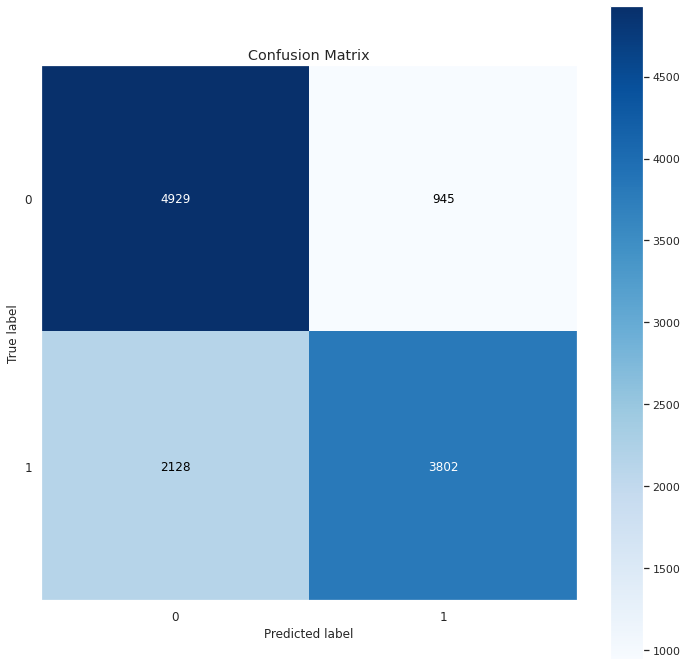

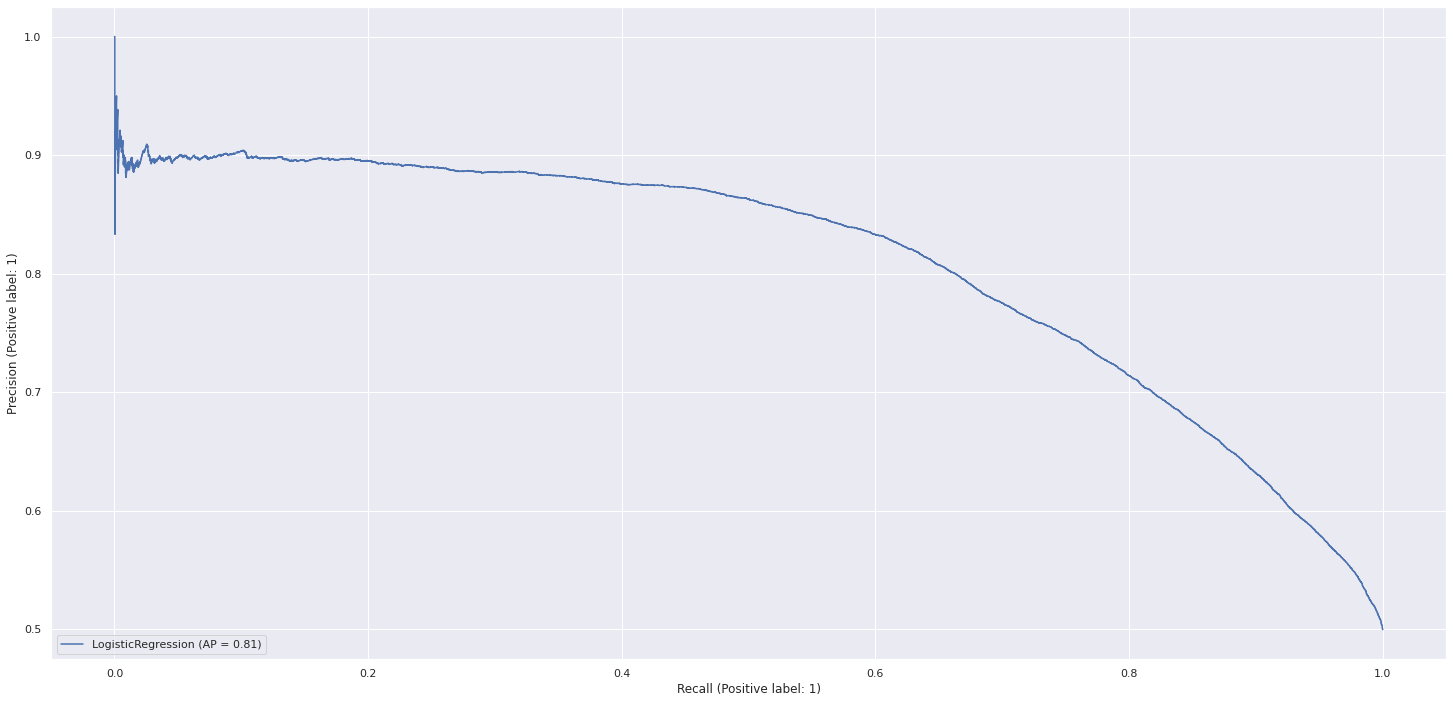

In [93]:
#confusion_matrix
mt.plot_confusion_matrix(y_test,yhat_log, normalize = False, figsize = (12,12))

#precision_recall_curve
plot_precision_recall_curve(logreg, X_train, y_train)

### 8.2.1. Logistic Regression - Cross-Validation

In [94]:
#cross validation scores
log_cv = cross_val_score(logreg,X_train, y_train.ravel(), cv = 10, n_jobs = -1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(log_cv),4),np.round(np.std(log_cv),4)))

Average: 0.7479 +/- Std 0.0066


## 8.3. Support Vector Machine

              precision    recall  f1-score   support

           0       0.72      0.82      0.76      5874
           1       0.79      0.68      0.73      5930

    accuracy                           0.75     11804
   macro avg       0.75      0.75      0.75     11804
weighted avg       0.75      0.75      0.75     11804



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

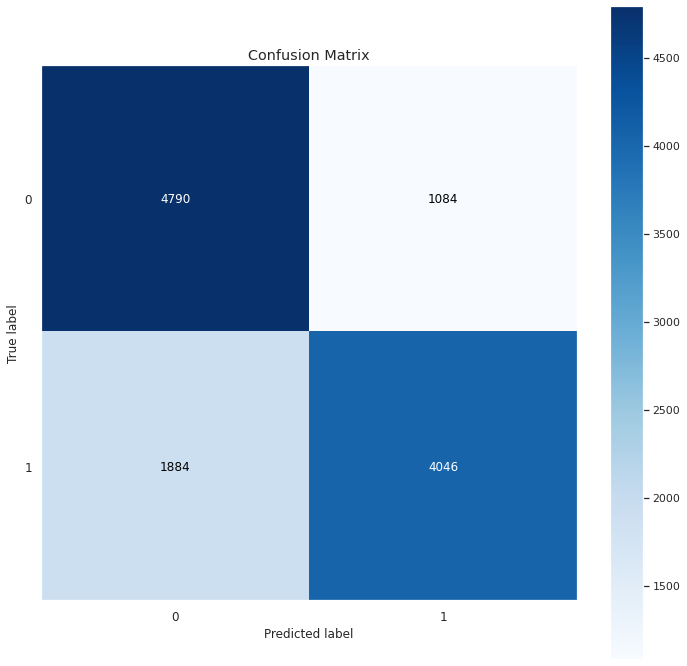

In [95]:
#define model
model_svm = svm.SVC()

#training model
model_svm.fit(X_train,y_train)

#predict
yhat_svm = model_svm.predict(X_test)

#result_svm
result_svm = pd.DataFrame(["Support Vector Machine",accuracy_score(y_test,yhat_svm),cohen_kappa_score(y_test,yhat_svm),
                          recall_score(y_test,yhat_svm), f1_score(y_test,yhat_svm),roc_auc_score(y_test,yhat_svm),
                          precision_score(y_test,yhat_svm)]).T
result_svm.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","roc_auc_score","Precision_score"]

#performance
print(classification_report(y_test, yhat_svm)) #classification report
mt.plot_confusion_matrix(y_test, yhat_svm, normalize = False, figsize = (12,12))

/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


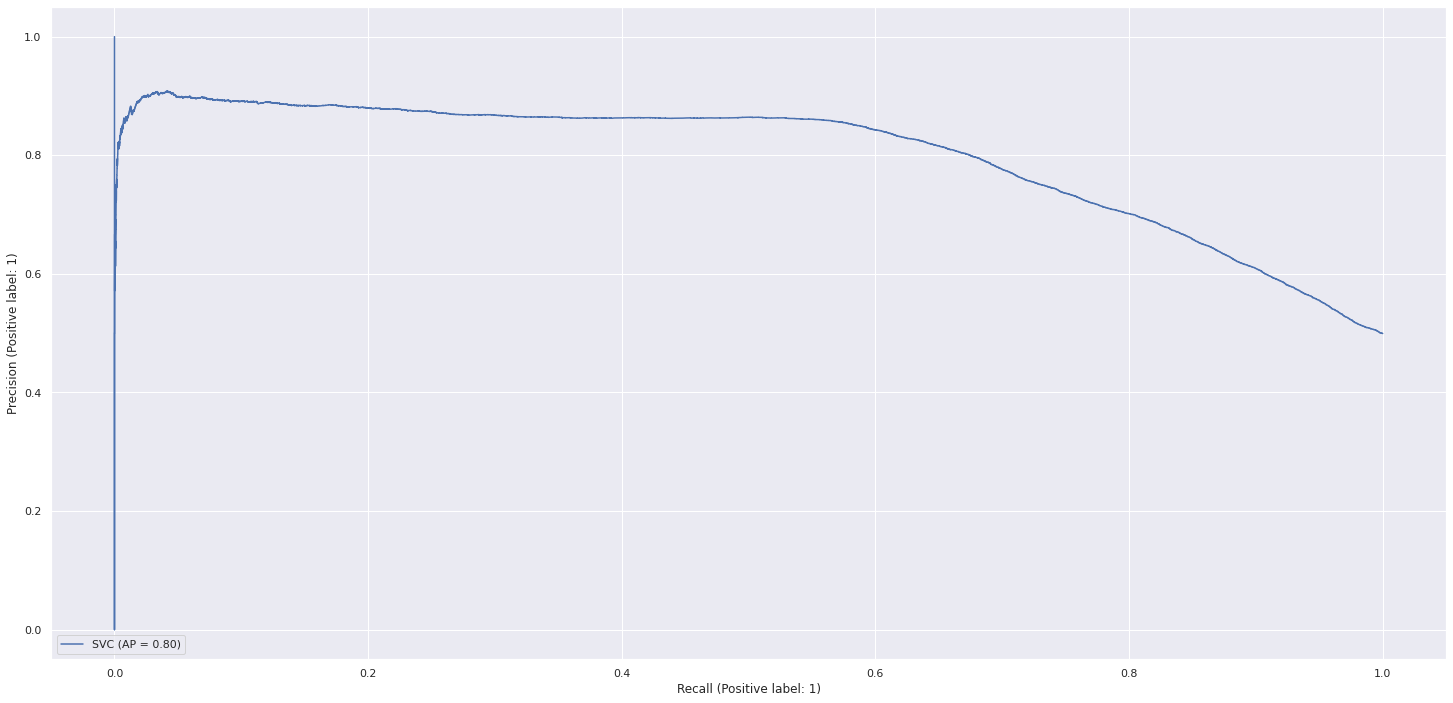

In [96]:
#precision_recall_curve
plot_precision_recall_curve(model_svm, X_train, y_train)

### 8.3.1. Support Vector Machine - Cross-Validation

In [97]:
#cross validation scores
svm_cv = cross_val_score(model_svm,X_train, y_train.ravel(), cv = 10, n_jobs = -1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(svm_cv),4),np.round(np.std(svm_cv),4)))

Average: 0.7508 +/- Std 0.0056


## 8.4. XGBoost Classifier

In [98]:
#model definition
xgb_model = xgb.XGBClassifier(n_jobs = -1)

#fit model
xgb_model.fit(X_train,y_train)

#prediction
yhat_xgb = xgb_model.predict(X_test)

# AUC-ROC
xgb_cv = cross_val_predict(xgb_model, X_train, y_train, cv=5)
xgb_roc = roc_auc_score(y_train, xgb_cv)


#performance
result_xgb = pd.DataFrame(["XGBoost Classifier",accuracy_score(y_test,yhat_xgb),cohen_kappa_score(y_test,yhat_xgb),
                          recall_score(y_test,yhat_xgb), f1_score(y_test,yhat_xgb),xgb_roc,
                          precision_score(y_test,yhat_xgb)]).T
result_xgb.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","roc_auc_score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_xgb))

/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:47:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:47:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:47:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:47:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:47:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:47:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.72      0.82      0.77      5874
           1       0.80      0.68      0.73      5930

    accuracy                           0.75     11804
   macro avg       0.76      0.75      0.75     11804
weighted avg       0.76      0.75      0.75     11804



In [99]:
#summary metrics
result_xgb

,Model,Accuracy,Kappa Score,Recall,F1-Score,roc_auc_score,Precision_score
0,XGBoost Classifier,0.750847,0.502035,0.677909,0.732174,0.757048,0.795882


/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


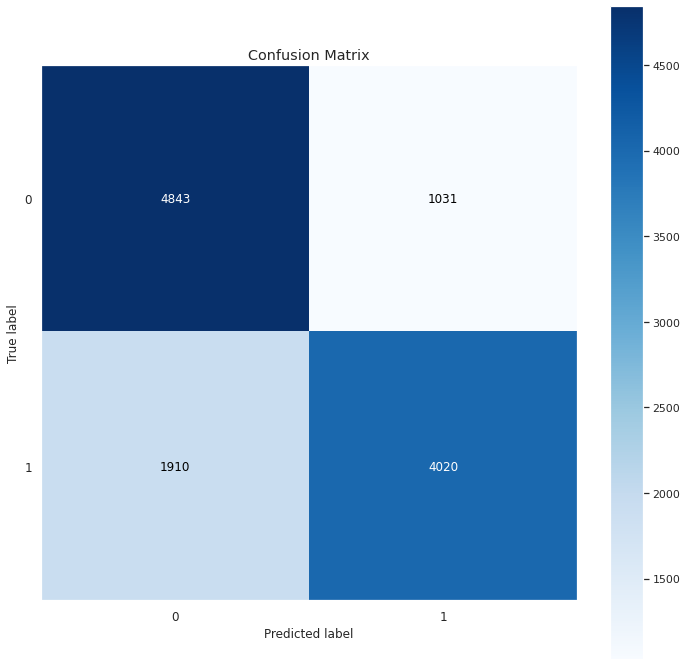

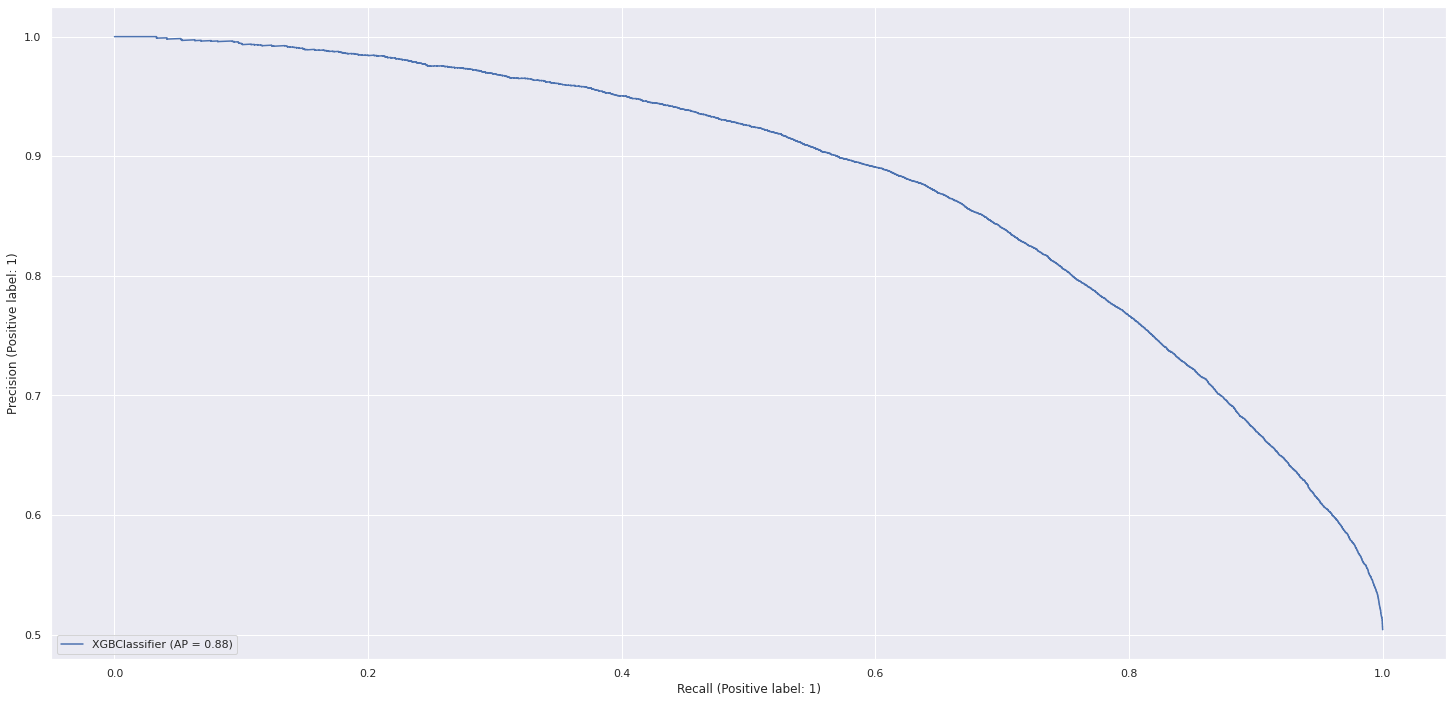

In [100]:
#confusion_matrix
mt.plot_confusion_matrix(y_test,yhat_xgb, normalize = False, figsize = (12,12))

#precision_recall_curve
plot_precision_recall_curve(xgb_model, X_train, y_train)

### 8.4.1. XGBoost Classifier - Cross-Validation

In [ ]:
#cross validation scores
xgb_cv = cross_val_score(xgb_model,X_train, y_train.ravel(), cv = 10, n_jobs = -1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(xgb_cv),4),np.round(np.std(xgb_cv),4)))

/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in

## 8.5. K-Nearest Neighbors

In [ ]:
#model definition
knn = KNeighborsClassifier(n_neighbors = 5)

#fit model
knn.fit(X_train,y_train)

#predict model
yhat_knn = knn.predict(X_test)

# AUC-ROC
knn_cv = cross_val_predict(knn, X_train, y_train, cv=5)
knn_roc = roc_auc_score(y_train, knn_cv)


#performance
result_knn = pd.DataFrame(["KNearestNeighbors",accuracy_score(y_test,yhat_knn),cohen_kappa_score(y_test,yhat_knn),
                          recall_score(y_test,yhat_knn), f1_score(y_test,yhat_knn),knn_roc,
                          precision_score(y_test,yhat_knn)]).T
result_knn.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","roc_auc_score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_knn))

In [ ]:
#confusion_matrix
mt.plot_confusion_matrix(y_test,yhat_knn, normalize = False, figsize = (12,12))

#precision_recall_curve
plot_precision_recall_curve(knn, X_train, y_train)

### 8.5.1. KNN - Cross-Validation

In [ ]:
#cross validation scores
knn_cv = cross_val_score(knn,X_train, y_train.ravel(), cv = 10, n_jobs = -1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(knn_cv),4),np.round(np.std(knn_cv),4)))

## 8.6. LGBM Classifier

In [ ]:
#define model
model_lgbm = LGBMClassifier(random_state=42, n_jobs=-1)

#training model
model_lgbm.fit(X_train, y_train)

#predict model
yhat_lgbm = model_lgbm.predict(X_test)

# AUC-ROC
lgbm_cv = cross_val_predict(model_lgbm, X_train, y_train, cv=5)
lgbm_roc = roc_auc_score(y_train, lgbm_cv)


#performance
result_lgbm = pd.DataFrame(["LGBM Classifier",accuracy_score(y_test,yhat_lgbm),cohen_kappa_score(y_test,yhat_lgbm),
                          recall_score(y_test,yhat_lgbm), f1_score(y_test,yhat_lgbm),lgbm_roc,
                           precision_score(y_test,yhat_lgbm)]).T
result_lgbm.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","roc_auc_score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_lgbm))

In [ ]:
#result lgbg
result_lgbm

In [ ]:
#confusion_matrix
mt.plot_confusion_matrix(y_test,yhat_lgbm, normalize = False, figsize = (12,12))

#precision_recall_curve
plot_precision_recall_curve(model_lgbm, X_train, y_train)

### 8.6.1. LGBM - Cross-Validation

In [ ]:
#cross validation scores
lgbm_cv = cross_val_score(model_lgbm,X_train, y_train.ravel(), cv = 10, n_jobs = -1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(lgbm_cv),4),np.round(np.std(lgbm_cv),4)))

## 8.7. Random Forest Classifier

In [ ]:
#define model
rf = RandomForestClassifier(n_jobs = -1)

#training model
rf.fit(X_train, y_train)

#predict model
yhat_rf = rf.predict(X_test)

# AUC-ROC
rf_cv = cross_val_predict(rf, X_train, y_train, cv=5)
rf_roc = roc_auc_score(y_train, rf_cv)

#performance
result_rf = pd.DataFrame(["Random Forest Classifier",accuracy_score(y_test,yhat_rf),cohen_kappa_score(y_test,yhat_rf),
                          recall_score(y_test,yhat_rf), f1_score(y_test,yhat_rf),rf_roc,
                           precision_score(y_test,yhat_rf)]).T
result_rf.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","roc_auc_score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_rf))

In [ ]:
#confusion_matrix
mt.plot_confusion_matrix(y_test,yhat_rf, normalize = False, figsize = (12,12))

#precision_recall_curve
plot_precision_recall_curve(rf, X_train, y_train)

### 8.7.1. RandomForestClassifier - Cross-Validation - Real Performance

In [ ]:
#cross validation scores
rf_cv = cross_val_score(rf,X_train, y_train.ravel(), cv = 10, n_jobs = -1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(rf_cv),4),np.round(np.std(rf_cv),4)))

## 8.8. Performance Machine Learning Model

### 8.8.1. Summary Metrics

In [ ]:
#concat all the models as a dataframe
result_model = pd.concat([result_log,result_svm,result_xgb,result_knn,result_lgbm,result_rf])
result_model.sort_values("Accuracy", ascending = False)

In [ ]:
accuracy = pd.DataFrame([np.mean(log_cv),np.mean(svm_cv),np.mean(xgb_cv),np.mean(knn_cv),np.mean(lgbm_cv),np.mean(rf_cv)])
std = pd.DataFrame([np.std(log_cv),np.std(svm_cv),np.std(xgb_cv),np.std(knn_cv),np.std(lgbm_cv),np.std(rf_cv)])
models = pd.DataFrame(['Logistc Regression', "Support Vector Machine","XGBoost Classifier", "KNearest Neighbors","LGBM Classifier","Random Forest Classifier"])
colunas = ['Modelo']

models.columns = colunas
models['Accuracy'] = accuracy
models['Standard Deviation'] = std


In [ ]:
models

### 8.8.2. Roc-curve

In [ ]:
#machine leraning model
lr_probs = logreg.predict_proba(X_test)
lgbm_probs = model_lgbm.predict_proba(X_test)
xgb_probs = xgb_model.predict_proba(X_test)
knn_probs = knn.predict_proba(X_test)
rf_probs = rf.predict_proba(X_test)


# keep probabilities for the positive outcome only
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = lr_probs[:, 1]
lgbm_probs = lgbm_probs[:,1]
xgb_probs = xgb_probs[:,1]
knn_probs = knn_probs[:,1]
rf_probs = rf_probs[:,1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
lgbm_auc = roc_auc_score(y_test, lgbm_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)
knn_auc = roc_auc_score(y_test, knn_probs)
rf_auc = roc_auc_score(y_test, rf_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('LGBM: ROC AUC=%.3f' % (lgbm_auc))
print('XGBoostClassifier: ROC AUC=%.3f' % (xgb_auc))
print('KNearestNeighbors: ROC AUC=%.3f' % (knn_auc))
print('RandomForestClassifier: ROC AUC=%.3f' % (rf_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, lgbm_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

#plot
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.plot(lgbm_fpr, lgbm_tpr, marker='.', label='LGBM')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoostClassifier')
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN')
plt.plot(rf_fpr, rf_tpr, marker='.', label='RandomForestClassifier')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# 9.0. HYPERPARAMETER FINE TUNNING

In machine learning, hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a parameter whose value is used to control the learning process. By contrast, the values of other parameters (typically node weights) are learned. 

Therefore, we will use the ** RandomSearchCV ** algorithm beacuse, the method described herein is a type of local random search, where every iteration is dependent on the prior iteration's candidate solution. So, we will spend less time to obtain the result.

## 9.1. Random Search CV

From the model we choose, we will apply the RandomSearchCv technique to obtain the best parameters from our algorithm. This will allow us to increase the performance of the model.

In [ ]:
#define model
model_lgbm = LGBMClassifier(n_jobs = -1, random_state = 42)

#parameters
parameters = {'max_depth': np.arange(2, 12, 2), 
         'num_leaves': 2 ** np.arange(2, 10, 2),
         'min_data_in_leaf': np.arange(100, 1050, 50), 
         'learning_rate': np.linspace(0.001, 0.6, 15),
         'colsample_bytree': np.linspace(0.1, 1, 5),
         'subsample': np.linspace(0.25, 1, 15),
         'n_estimators': np.arange(10, 105, 15)}

#define RandomSearchCV
lgbm_random_cv = RandomizedSearchCV(estimator=model_lgbm, param_distributions=parameters,
                                scoring='accuracy', n_iter=100, cv=10, verbose=2,
                                random_state=42, n_jobs=-1)

#fit RandomSearchCV
lgbm_random_cv.fit(X_train, np.ravel(y_train))

In [ ]:
#get the best parameters to our model
lgbm_random_cv.best_estimator_

## 9.2. Fit the model using the best parameters 

In [ ]:
#define model
lgbm_hyper = LGBMClassifier(learning_rate=0.17214285714285713, max_depth=8,
               min_data_in_leaf=950, n_estimators=85, num_leaves=256,
               random_state=42, subsample=0.5714285714285714)

#fit model
lgbm_hyper.fit(X_train, y_train)

#predict model
yhat_lgbm_hyper = lgbm_hyper.predict(X_test)

#Performance
#performance
result_lgbm_hyper = pd.DataFrame(["LGBM Classifier",lgbm_random_cv.best_score_,accuracy_score(y_test,yhat_lgbm_hyper),cohen_kappa_score(y_test,yhat_lgbm_hyper),
                          recall_score(y_test,yhat_lgbm_hyper), f1_score(y_test,yhat_lgbm_hyper),lgbm_auc,
                           precision_score(y_test,yhat_lgbm_hyper)]).T
result_lgbm_hyper.columns = ["Model",'Best Score','Accuracy',"Kappa Score","Recall","F1-Score","ROC_AUC","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_lgbm_hyper))

In [ ]:
pickle.dump(lgbm_hyper,open("./parameters/model_cardio_lgbm.pkl", "wb"))

In [ ]:
result_lgbm_hyper

In [ ]:
#confusion_matrix
mt.plot_confusion_matrix(y_test,yhat_lgbm_hyper, normalize = False, figsize = (15,10))

#precision_recall_curve
plot_precision_recall_curve(lgbm_hyper, X_train, y_train)

In [ ]:
lgbm_hyper = pickle.load(open("./model/model_cardio.pkl", "rb"))

## 9.3. Changing the Threshold 

In [ ]:
#predict model and setting the threshold
yhat_tunned = (lgbm_hyper.predict_proba(X_test)[:,1] >= 0.40).astype(bool)

In [122]:
#machine learning performance
result_lgbm_tunned = pd.DataFrame(["LGBM Classifier",lgbm_random_cv.best_score_,accuracy_score(y_test,yhat_tunned),cohen_kappa_score(y_test,yhat_tunned),
                          recall_score(y_test,yhat_tunned), f1_score(y_test,yhat_tunned),lgbm_auc,
                           precision_score(y_test,yhat_tunned)]).T
result_lgbm_tunned.columns = ["Model",'Best Score','Accuracy',"Kappa Score","Recall","F1-Score","ROC_AUC","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_tunned))

NameError: name 'yhat_tunned' is not defined

In [123]:
#confusion_matrix
mt.plot_confusion_matrix(y_test,yhat_tunned, normalize = False, figsize = (15,12))

#precision_recall_curve
plot_precision_recall_curve(lgbm_hyper, X_train, y_train)

NameError: name 'yhat_tunned' is not defined

In [124]:
result_lgbm_tunned

NameError: name 'result_lgbm_tunned' is not defined

## 9.4. Real Performance - Cross-Validation 

We will apply the cross-validation technique to obtain the real performance of our model.

In [125]:
#cross validation scores
lgbm_cv = cross_val_score(lgbm_hyper,X_train, y_train.ravel(), cv = 10, n_jobs = -1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(lgbm_cv),4),np.round(np.std(lgbm_cv),4)))

/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ub/anaconda3/envs/cardio/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a futu

Average: 0.7603 +/- Std 0.0057


# 10.0. BUSINESS PERFORMANCE

Let's remember what is our business problem:
- **Each diagnosis costs about $1000,00**

- **The price will vary according to the precision, the customer pays $500.00 for every 5% precision above 50%.**

- **If the diagnostic precision is 50% or below, the customer doesn't pay for it.**

What did we get?

- **Precision = 76.04%**
- **5% above 50% = $500,00**

- **25% above 50% = $2500,00**

## 10.1. Accuracy and Precision

In [126]:
#calculate Accuracy and Precision
result_lgbm_tunned

NameError: name 'result_lgbm_tunned' is not defined

## 10.2. Confidence Interval

In [127]:
# binomial confidence interval
interval = 1.96 * sqrt( (0.2385 * (1 - 0.2385)) / X_test.shape[0])
print('%.3f' % interval)

conf_interval = ['Confidence Interval', "Worst Scenario", "Best Scenario"]
results = [interval, 0.2385 + interval, 0.2385 - interval]

conf = pd.DataFrame(results).T
conf.columns = conf_interval


0.008


## 10.3. Financial Return

In [128]:
#calculate financial feedback
business_perf = ['LGBM Classifier', "$ {:,.2f}".format(500*70000), "$ {:,.2f}".format(2500*len(df_raw)),"$ 140.000.000,00", "500%"]
df_business = pd.DataFrame(business_perf).T
df_business.columns = ["Model","Worst Scenario","Best Scenario","Gain","% Gain"]
df_business

,Model,Worst Scenario,Best Scenario,Gain,% Gain
0,LGBM Classifier,"$ 35,000,000.00","$ 175,000,000.00","$ 140.000.000,00",500%


With a data set of 70000 people and each exam costing approximately $ 2500.00, our financial return will be, in the worst case, $ 35,000,000.00 and in the best case, $ 175,000,000.00.

# 11.0. DEPLOY MODEL TO PRODUCTION

In [130]:
pickle.dump(lgbm_hyper, open("./model/model_cardio.pkl", "wb"))